In [1]:
import numpy as np
import pandas as pd
from scipy import signal
from scipy.stats import zscore
from scipy.integrate import cumtrapz
import data_processing as dp
import seaborn as sns
import matplotlib.pyplot as plt
import os
import pywt
import h5py
from nitime.algorithms import autoregressive
from sklearn.preprocessing import StandardScaler,normalize
from sklearn.neighbors import LocalOutlierFactor as LOF
#from sklearn.ensemble import IsolationForest
import joblib

In [114]:
import imp
imp.reload(dp)

<module 'data_processing' from 'E:\\Document\\jupyter\\Master Thesis\\data_processing.py'>

In [2]:
for dirname, _, filenames in os.walk('.\data'):
    for filename in filenames:
        depth = len(dirname.split(os.path.sep))
        if depth == 2:
            print(os.path.join(dirname,filename))

.\data\G04_FoG_trial_1_emg.csv
.\data\G04_FoG_trial_2_emg.csv
.\data\G06_FoG_trial_1_emg.csv
.\data\G06_FoG_trial_2_emg.csv
.\data\G06_FoG_trial_3_emg.csv
.\data\G07_Freezing_Trial1_trial_1_emg.csv
.\data\G08_FoG_1_trial_1_emg.csv
.\data\G08_FoG_2_trial_1_emg.csv
.\data\G11_FoG_trial_1_emg.csv
.\data\G11_FoG_trial_2_emg.csv
.\data\P379_M050_2_OFF_A_FoG_trial_1_emg.csv
.\data\P379_M050_2_OFF_A_FoG_trial_2_emg.csv
.\data\P379_M050_2_OFF_A_FoG_trial_3_emg.csv
.\data\P379_M050_2_OFF_B_FoG_trial_1_emg.csv
.\data\P379_M050_2_OFF_B_FoG_trial_2_emg.csv
.\data\P379_M050_2_OFF_B_FoG_trial_3_emg.csv
.\data\P551_M050_2_A_FoG_trial_1_emg.csv
.\data\P551_M050_2_B_FoG_trial_1_emg.csv
.\data\P551_M050_2_B_FoG_trial_2_emg.csv
.\data\P812_M050_2_B_FoG_trial_1_emg.csv
.\data\P812_M050_2_B_FoG_trial_2_emg.csv


In [28]:
emg_data = pd.read_csv('.\data\正常\P231_M050_B_Walking_trial_4_emg.csv')
emg_data2 = pd.read_csv('.\data\P812_M050_2_B_FoG_trial_2_emg.csv')

In [5]:
emg_data.head()

Time  Label1  Label2  LEFT_TA  LEFT_TS  LEFT_BF  LEFT_RF  RIGHT_TA  \
0  0.000       0       0       -3        2     -4.0     -1.0       0.0   
1  0.001       0       0       -5       10      0.0     -2.0      -4.0   
2  0.002       0       0       -6       11      1.0      0.0      -4.0   
3  0.003       0       0        0       -2      0.0     -3.0      -6.0   
4  0.004       0       0        0       -8     -3.0     -3.0      -4.0   

   RIGHT_TS  RIGHT_BF  RIGHT_RF  
0       2.0       1.0      -2.0  
1       0.0      -7.0      -2.0  
2      -1.0      -2.0      -3.0  
3      -2.0      -5.0      -8.0  
4      -3.0       0.0       2.0

In [6]:
emg_data2.head()

Time  Label1  Label2  LEFT_TA  LEFT_TS  LEFT_BF  LEFT_RF  RIGHT_TA  \
0  0.000       0       0      -14       -4       -4       -1        -9   
1  0.001       0       0       -5       -4       -4       -4        -6   
2  0.002       0       0        6        0       -9        4        -6   
3  0.003       0       0       28        1       -1       -1         1   
4  0.004       0       0       43        3       -2        0         1   

   RIGHT_TS  RIGHT_BF  RIGHT_RF  
0        -2       1.0      -1.0  
1        -1       0.0       6.0  
2        -6       0.0      -2.0  
3         2      -5.0       2.0  
4         2       3.0       1.0

In [7]:
emg_data.Label2.describe()

count    23301.0
mean         0.0
std          0.0
min          0.0
25%          0.0
50%          0.0
75%          0.0
max          0.0
Name: Label2, dtype: float64

In [31]:
emg_data2 = emg_data2.fillna({'LEFT_BF':emg_data.LEFT_BF.mean(),
                           'LEFT_RF':emg_data.LEFT_RF.mean(),
                           'RIGHT_TA':emg_data.RIGHT_TA.mean(),
                           'RIGHT_TS':emg_data.RIGHT_TS.mean(),
                           'RIGHT_BF':emg_data.RIGHT_BF.mean(),
                           'RIGHT_RF':emg_data.RIGHT_RF.mean()})
emg_data2.isna().sum()

Time        0
Label1      0
Label2      0
LEFT_TA     0
LEFT_TS     0
LEFT_BF     0
LEFT_RF     0
RIGHT_TA    0
RIGHT_TS    0
RIGHT_BF    0
RIGHT_RF    0
dtype: int64

In [2]:
df = pd.read_csv('./useful_data_label.csv',index_col=0)
df2 = pd.read_csv('./unuseful_data_label.csv',index_col=0)
df2.columns

Index(['G02_Walking_trial_1_emg.csv', 'G03_Walking_trial_1_emg.csv',
       'G03_Walking_trial_2_emg.csv',
       'G05_Walking_struct_fixed_trial_1_emg.csv',
       'G05_Walking_struct_fixed_trial_2_emg.csv',
       'G05_Walking_struct_fixed_trial_3_emg.csv', 'G09_FoG_trial_1_emg.csv',
       'G09_FoG_trial_2_emg.csv', 'G09_FoG_trial_3_emg.csv',
       'G09_Walking_trial_2_emg.csv',
       ...
       'P940_M100_B_Walking_2_trial_2_emg.csv',
       'P940_M100_B_Walking_2_trial_6_emg.csv',
       'P940_MSham_A_FoG_trial_1_emg.csv', 'P940_MSham_A_FoG_trial_3_emg.csv',
       'P940_MSham_A_Walking_trial_2_emg.csv',
       'P940_MSham_A_Walking_trial_4_emg.csv',
       'P940_MSham_A_Walking_trial_6_emg.csv',
       'P940_MSham_B_Walking_trial_2_emg.csv',
       'P940_MSham_B_Walking_trial_4_emg.csv',
       'P940_MSham_B_Walking_trial_6_emg.csv'],
      dtype='object', length=161)

In [436]:
data.LEFT_TA.mean()

-0.2232123066010551

In [7]:
df2.columns[4]
pd.read_csv('./data/正常/'+df2.columns[5]).isna().sum()

Time         0
Label1       0
Label2       0
LEFT_TA      0
LEFT_TS      0
LEFT_BF      0
LEFT_RF      0
RIGHT_TA     0
RIGHT_TS     0
RIGHT_BF    27
RIGHT_RF    29
dtype: int64

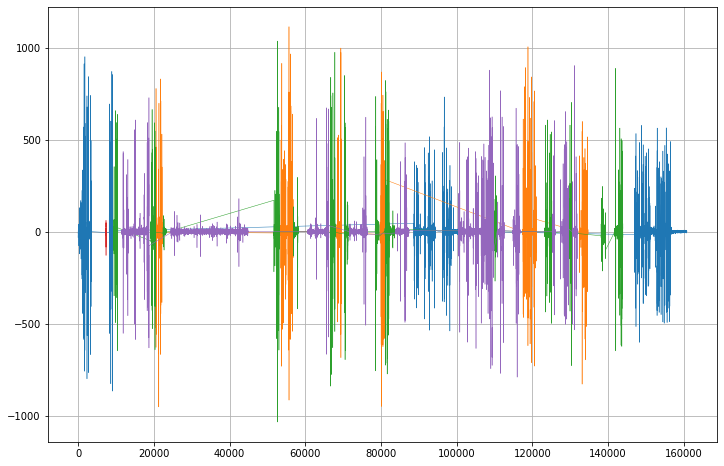

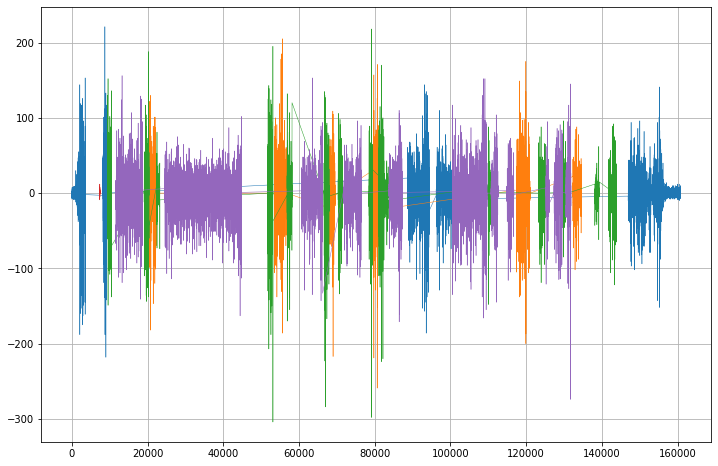

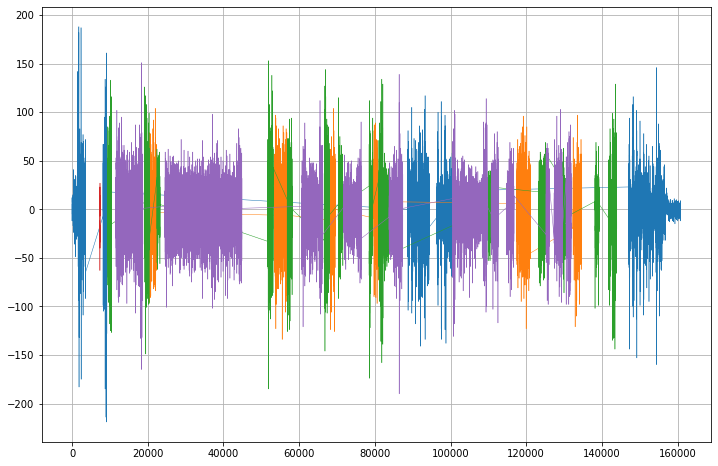

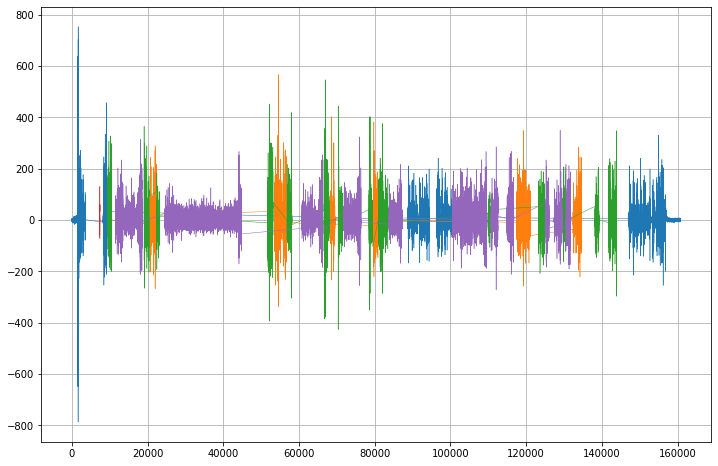

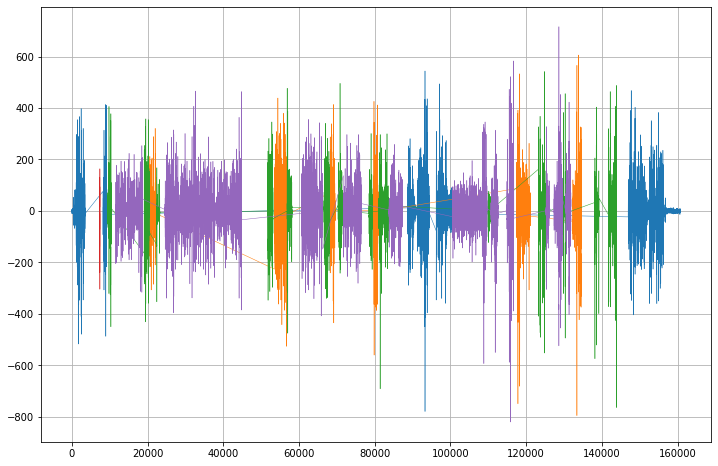

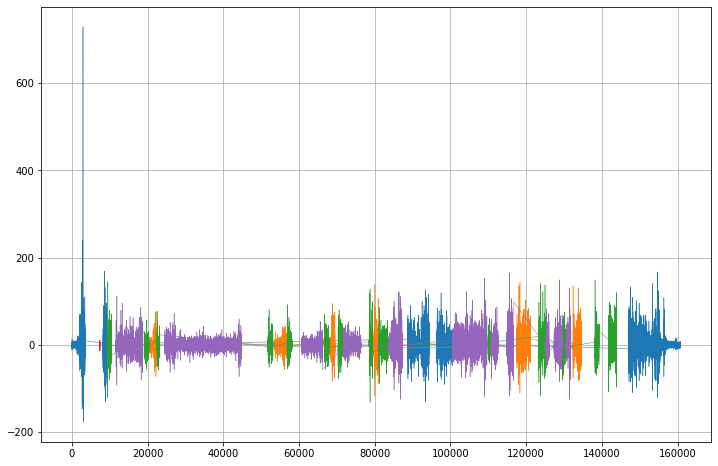

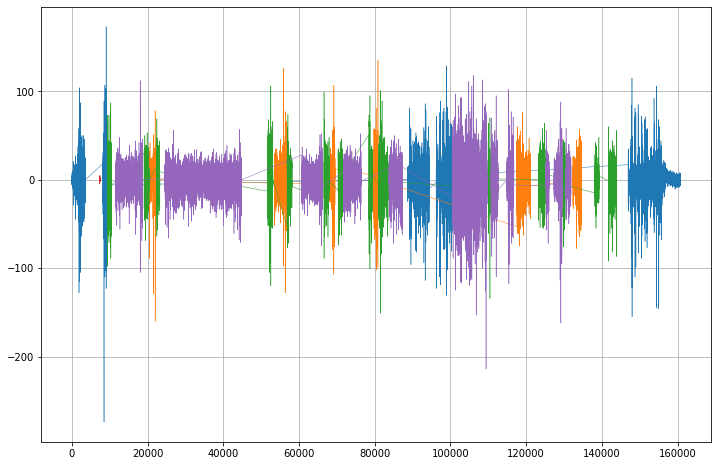

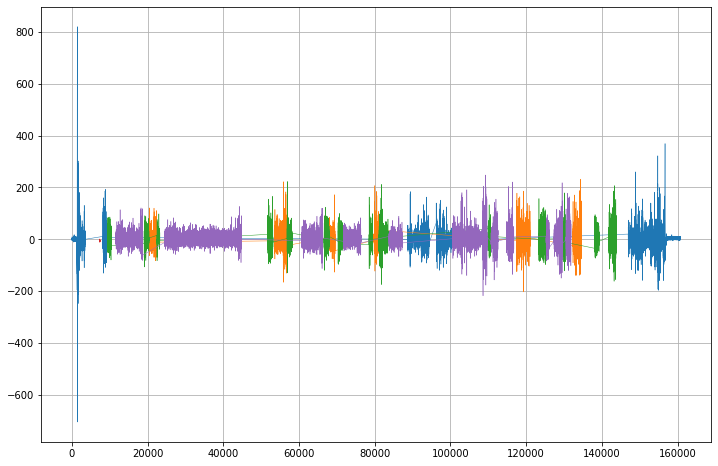

In [4]:
#data = pd.read_csv('./data/'+df.columns[5])
data = pd.read_csv('./data/'+df.columns[5])
"""data = data.fillna({'LEFT_TA':data.LEFT_TA.mean(),
                           'LEFT_TS':data.LEFT_TS.mean(),
                           'LEFT_BF':data.LEFT_BF.mean(),
                           'LEFT_RF':data.LEFT_RF.mean(),
                           'RIGHT_TA':data.RIGHT_TA.mean(),
                           'RIGHT_TS':data.RIGHT_TS.mean(),
                           'RIGHT_BF':data.RIGHT_BF.mean(),
                           'RIGHT_RF':data.RIGHT_RF.mean()})"""
data = data.dropna()
fn = 20
wn=2*fn/1000
fn1 = 300
wn1=2*fn1/1000
#b, a = signal.butter(4, [wn,wn1], 'bandpass')
b, a = signal.butter(4, [wn], 'highpass')
#x_filter = signal.filtfilt(b, a, x[1,:,1])
#sc = StandardScaler(with_mean=False)
#scs = []
m = 0
#x_filter = sc.fit_transform(np.array(data.iloc[:,3:]))
for i in data.columns[3:]:
    plt.figure(figsize=(12,8))
    #data.iloc[:,3:] = normalize(data.iloc[:,3:])
    #ind = abs(zscore(data.loc[:,i]))<10
    #data.loc[~ind,i] = data.loc[ind,i].mean()
    #ind = (lof.fit_predict(np.array(data.loc[:,i])[:,np.newaxis]))==1
    #data.loc[~ind,i] = data.loc[ind,i].mean()
    #x_filter = signal.filtfilt(b, a, data.loc[:,i])
    #ind = abs(zscore(x_filter))<10
    #x_filter[~ind]=x_filter[ind].mean()
    #ind = (lof.fit_predict(x_filter[:,np.newaxis]))==1
    #x_filter[~ind] = x_filter[ind].mean()
    #x_filter = sc.fit_transform(np.array(data.loc[:,i])[:,np.newaxis])
    #sc = joblib.load('./model/scalar%d'%m)
    #x_filter = sc.transform(np.array(data.loc[:,i])[:,np.newaxis])
    m += 1
    #scs += [sc]
    #data.loc[:20000,i].plot(linewidth=0.5)
    #sns.lineplot(data.Time[:20000],x_filter[:20000],linewidth=0.3)
    for j in set(data.Label2):
        ind = (data.Label2 == j) & (data.Label1 == j)
        data.loc[ind,i].plot(linewidth=0.5)
        #sns.lineplot(data.Time[ind],x_filter[ind],linewidth=0.3)
        #plt.ylim((-200,200))
        #plt.xlim((15000,18000))
        plt.grid(True)
        #sns.scatterplot(data.Time[ind],data.loc[ind,i],markers='.',alpha=0.5,size=0.1)

In [14]:
data.mean()

Time        80.486260
Label1       3.044779
Label2       3.330132
LEFT_TA      0.342819
LEFT_TS      0.219533
LEFT_BF      0.182983
LEFT_RF     -0.346592
RIGHT_TA    -0.293677
RIGHT_TS    -0.342656
RIGHT_BF     0.452535
RIGHT_RF     0.378259
dtype: float64

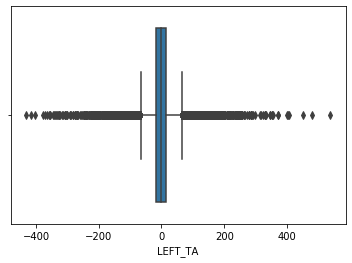

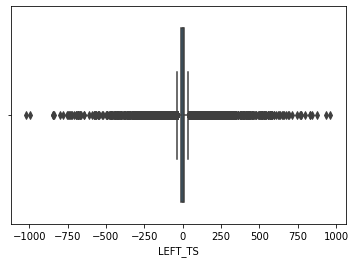

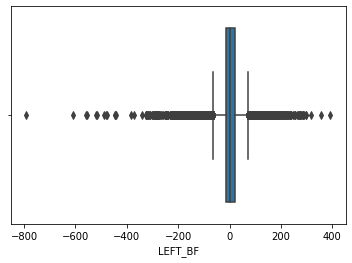

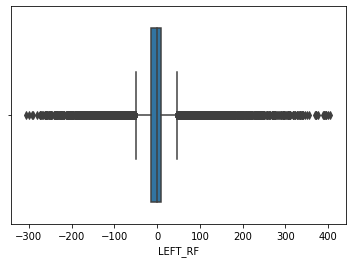

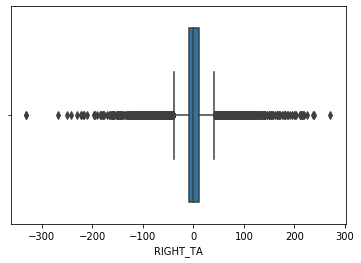

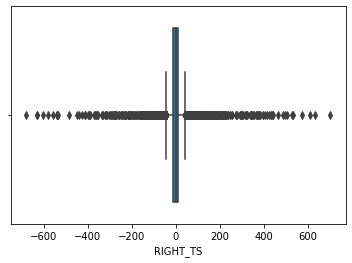

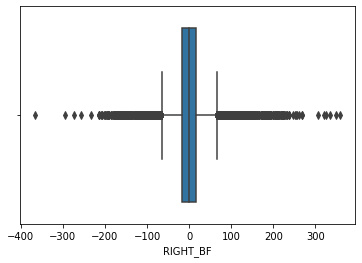

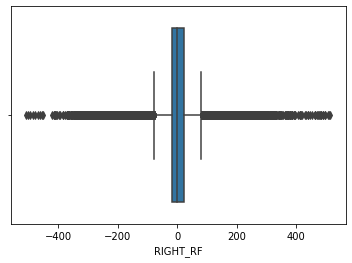

In [420]:
#sns.boxplot(np.clip(data.iloc[:,3],-300,300))
for i in range(8):
    plt.figure()
    sns.boxplot(data.iloc[:,3+i])
    #x_filter = signal.filtfilt(b, a, data.iloc[:,i+3])
    #x_filter = signal.filtfilt(b1, a1, x_filter)
    #ind = abs(zscore(x_filter))<10
    #sns.boxplot(x_filter[ind])

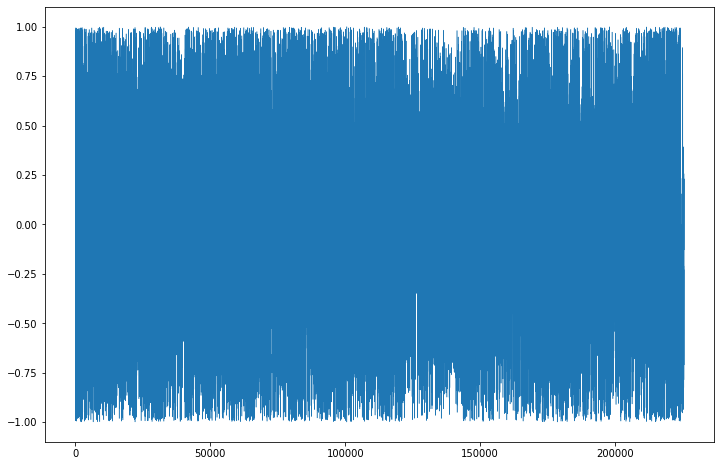

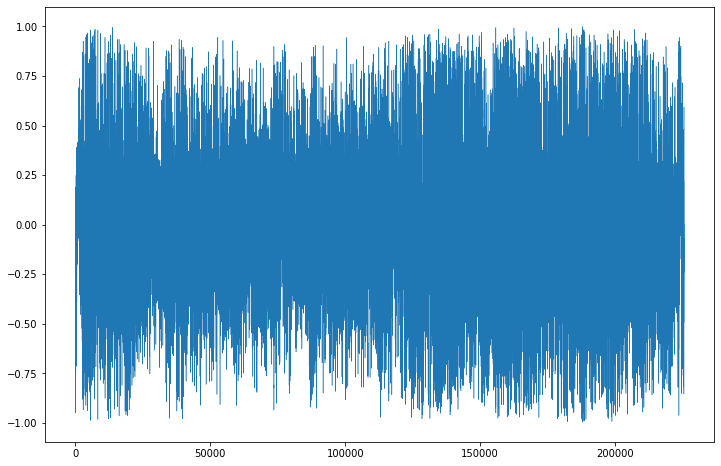

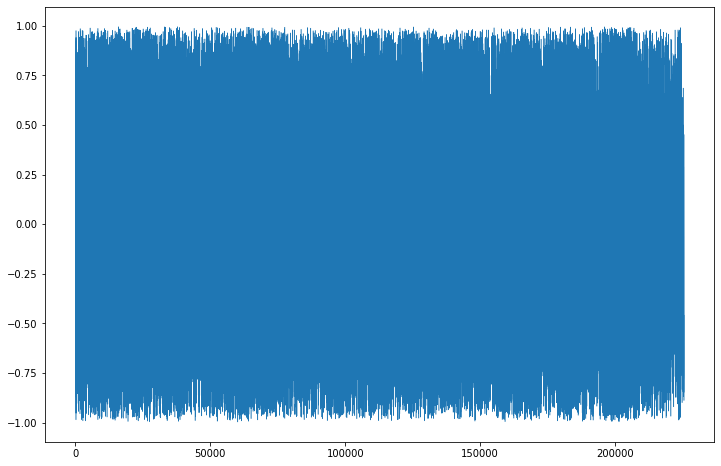

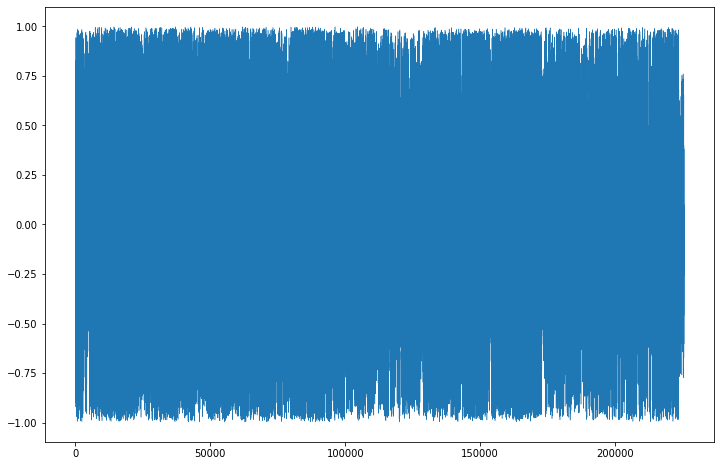

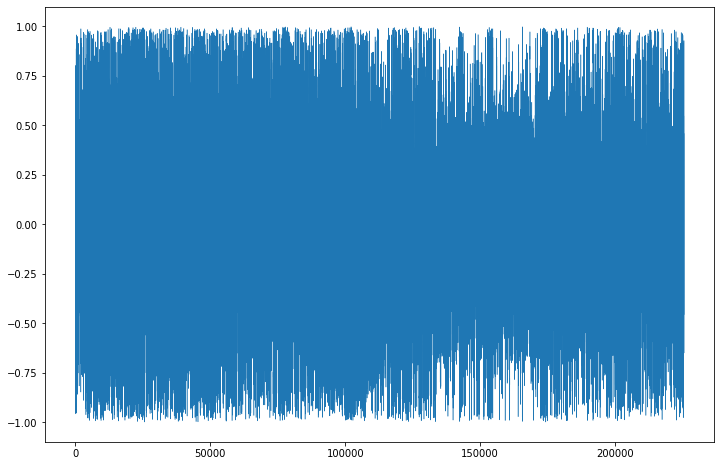

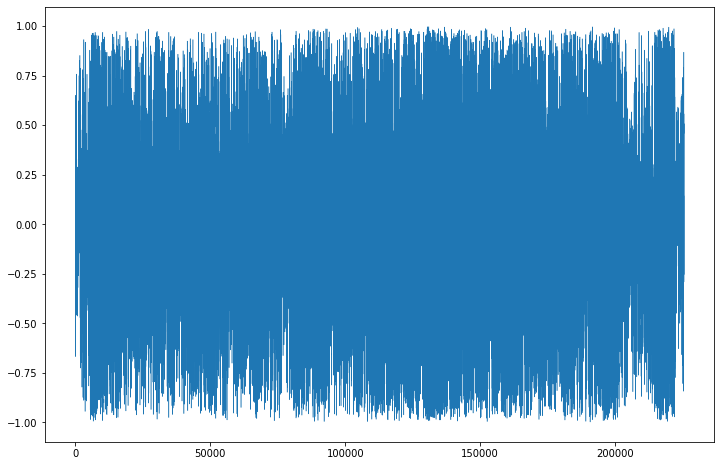

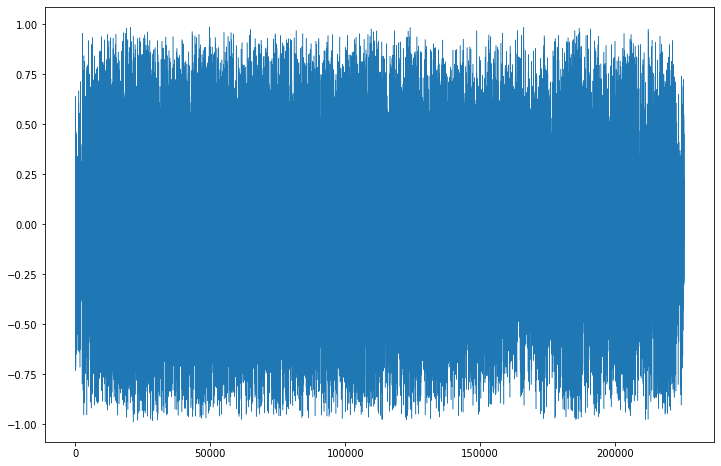

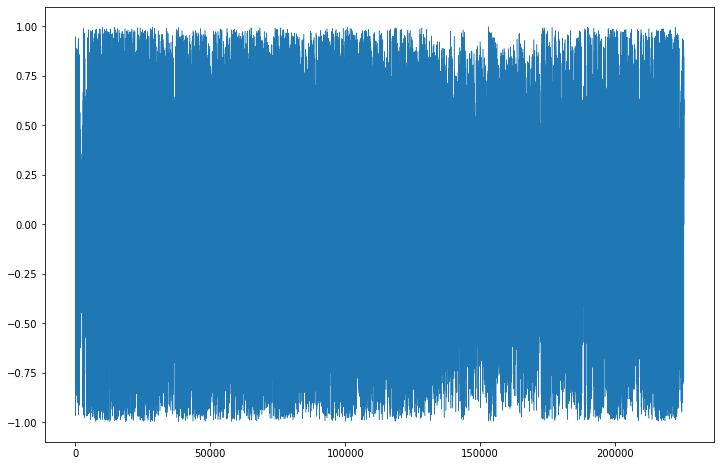

In [7]:
#lof = LOF(n_neighbors=5,metric='minkowski')
#ind = (lof.fit_predict(np.array(data.iloc[:,7])[:,np.newaxis]))==1

for i in range(8):
    ind = abs(zscore(data.iloc[:,i+3]))<10
    #ind = (lof.fit_predict(np.array(data.iloc[:,i+3])[:,np.newaxis]))==1
    plt.figure(figsize=(12,8))
    data.loc[ind,data.columns[i+3]].plot(linewidth=0.5)
    #data.loc[~ind,'LEFT_TA'].plot(linewidth=0.5)
    plt.scatter(x=data.index[~ind],y=data.loc[~ind,data.columns[i+3]],color='r')

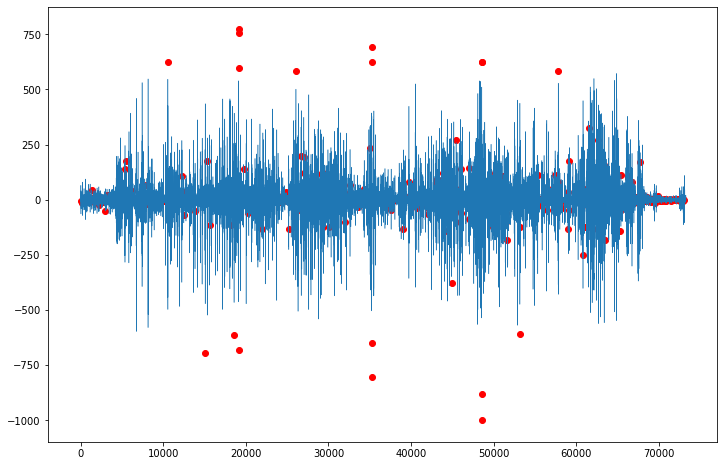

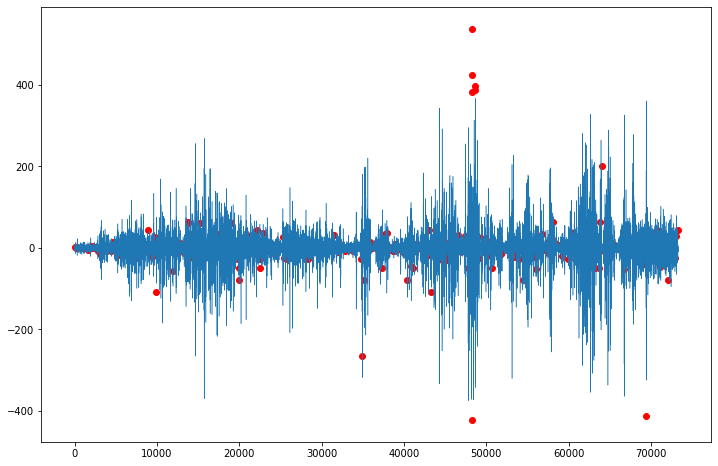

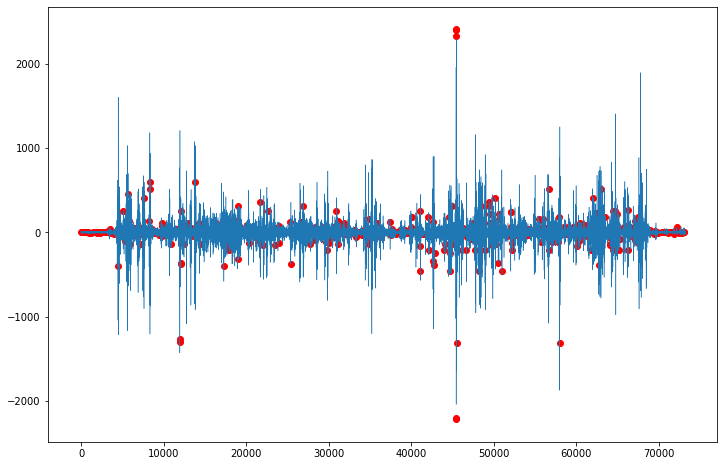

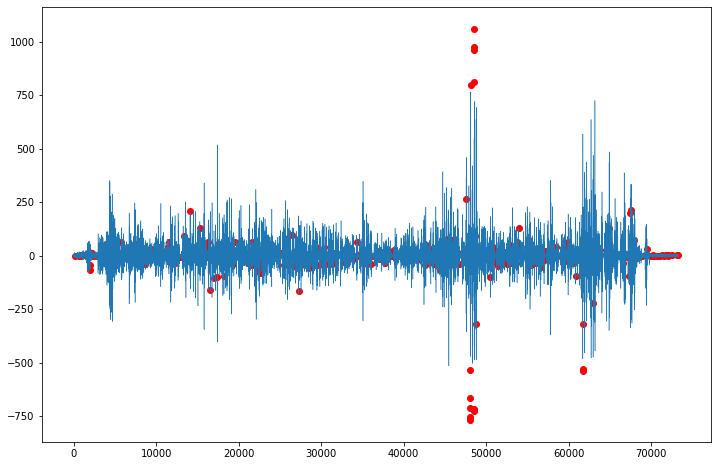

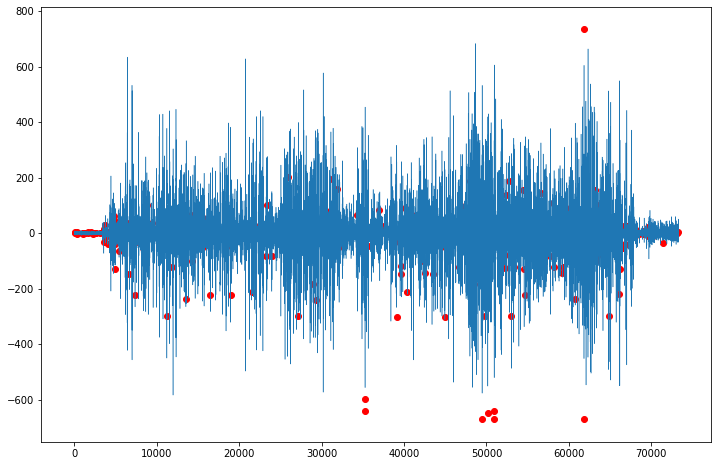

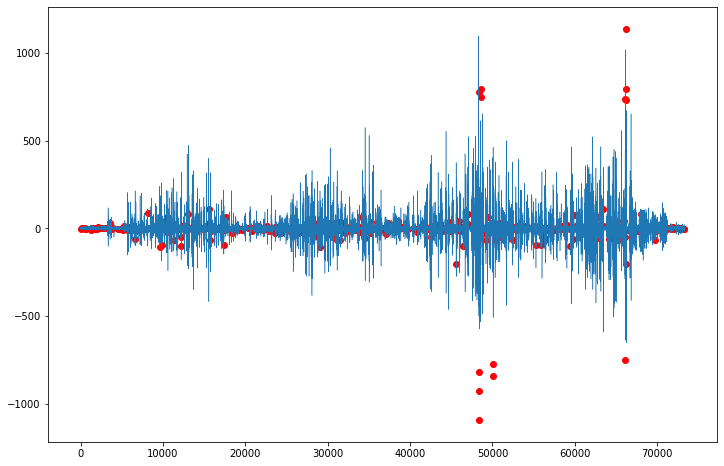

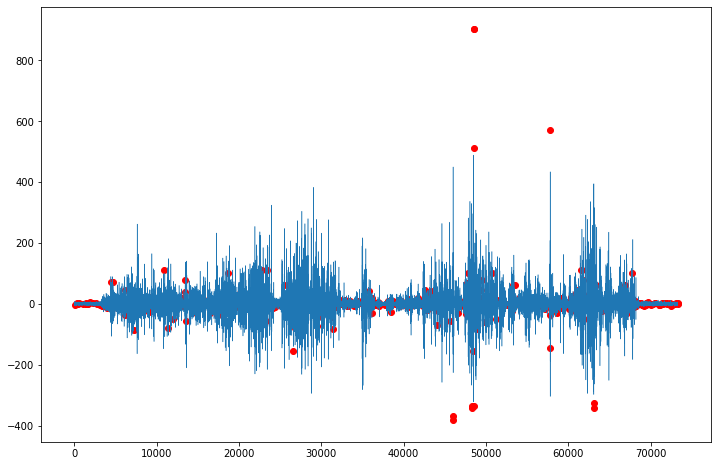

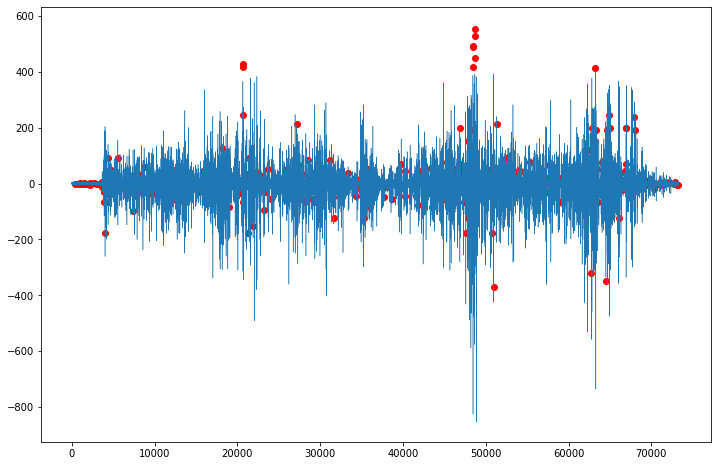

In [12]:
fs = 1000.0  # Sample frequency (Hz)
f0 = 50  # Frequency to be removed from signal (Hz)
Q = 100.0  # Quality factor
# Design notch filter
b1, a1 = signal.iirnotch(f0, Q, fs)
for i in range(8):
    x_filter = signal.filtfilt(b, a, data.iloc[:,i+3])
    #x_filter = signal.filtfilt(b1, a1, x_filter)
    plt.figure(figsize=(12,8))
    #ind = abs(zscore(x_filter))<10
    ind = (lof.fit_predict(x_filter[:,np.newaxis]))==1
    plt.plot(data.index[ind],x_filter[ind],linewidth=0.5)
    plt.scatter(data.index[~ind],x_filter[~ind],color='r')
    #x_filter[~ind]=x_filter[ind].mean()

In [128]:
ind=clf.fit_predict(np.array(data.iloc[:,7])[:,np.newaxis])

In [130]:
set(ind)

{-1, 1}

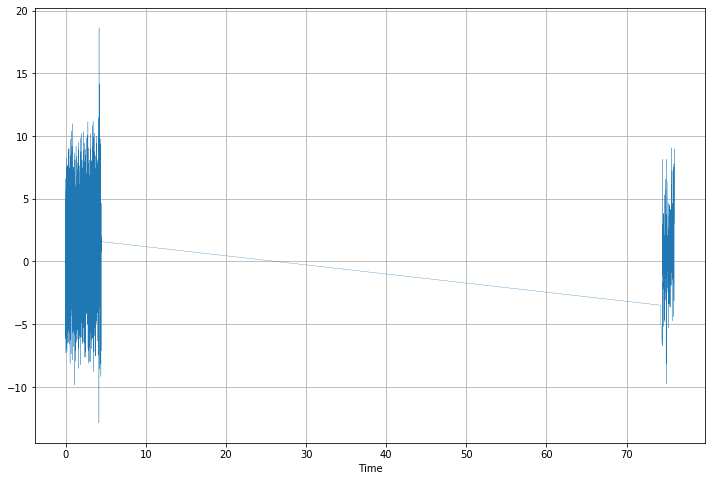

In [170]:
fs = 1000.0  # Sample frequency (Hz)
f0 = 9.5  # Frequency to be removed from signal (Hz)
Q = 100.0  # Quality factor
# Design notch filter
#b, a = signal.iirnotch(f0, Q, fs)
fn = 5
wn=2*fn/1000
fn1= 10
wn1=2*fn1/1000
b, a = signal.butter(4, [wn,wn1], 'bandpass')
temp = signal.filtfilt(b,a,data.iloc[:,5])
plt.figure(figsize=(12,8))
for j in set(data.Label2):
    ind = data.Label2 == j
    sns.lineplot(data.Time[ind],temp[ind],linewidth=0.3)
    #plt.ylim((-200,200))
    #plt.xlim((35,40))
    plt.grid(True)

5.6945986731585085


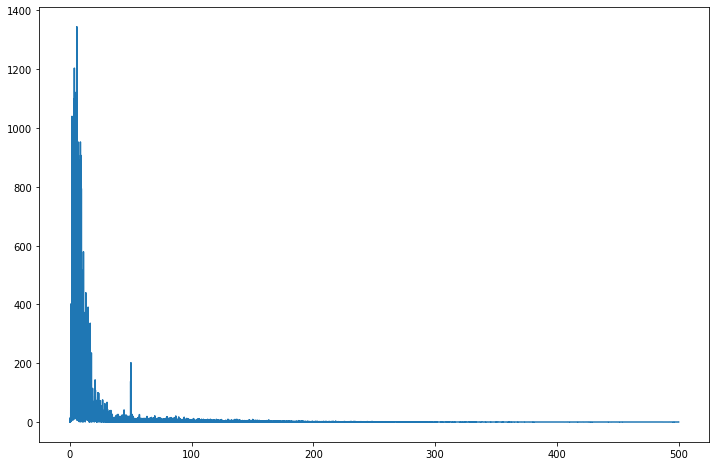

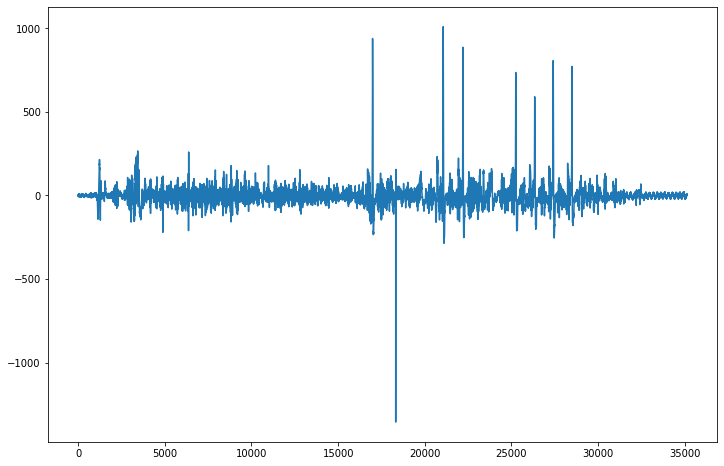

In [235]:
fs = 1000.0  # Sample frequency (Hz)
f0 = 4.58  # Frequency to be removed from signal (Hz)
Q = 100.0  # Quality factor
b, a = signal.iirnotch(f0, Q, fs)
temp = signal.filtfilt(b,a,data.iloc[:,2+7])
plt.figure(figsize=(12,8))
#freqs, power=signal.periodogram(np.clip(data.iloc[:,2+7],-200,200), 1e3)
freqs, power=signal.periodogram(temp, 1e3)
plt.plot(freqs,power)
plt.figure(figsize=(12,8))
#plt.plot((np.clip(data.iloc[:,2+7],-200,200)))
plt.plot(temp)
print(freqs[np.argmax(power)])

In [57]:
data.iloc[:,3:] = normalize(data.iloc[:,3:])

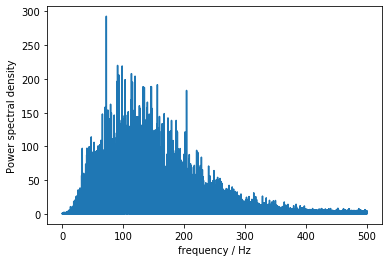

72.12029660459197


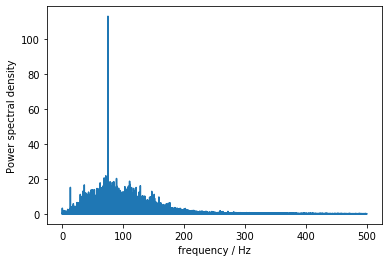

75.02240831395457


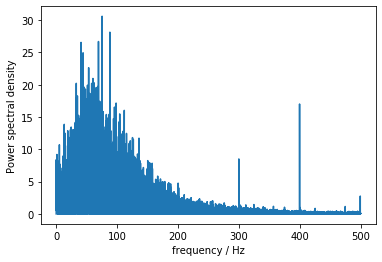

75.46744056312248


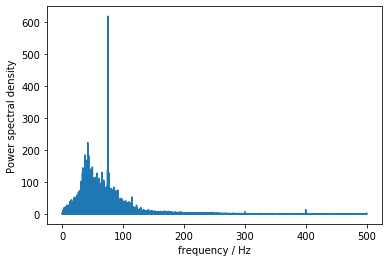

75.02240831395457


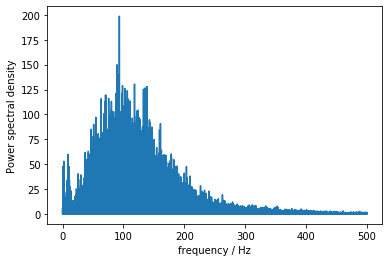

93.325143068466


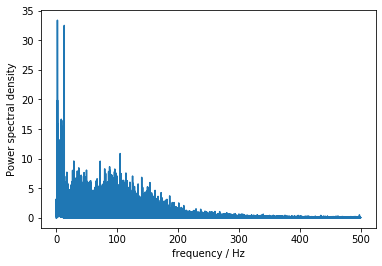

2.0559236299588184


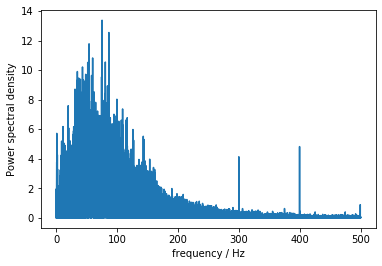

75.41729608434301


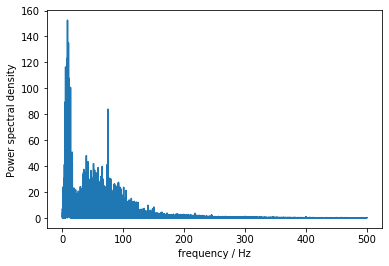

8.336519597089111


In [16]:
label = 6
ind = (data.Label2 == label) & (data.Label1 == label)
fn= 10
wn=2*fn/1000
b, a = signal.butter(4, wn, 'highpass')
for i in np.arange(3,11):
    plt.figure()
    freqs, power=signal.periodogram(data.loc[:,data.columns[i]], 1e3)
    #ind = (lof.fit_predict(np.array(data.iloc[:,i])[:,np.newaxis]))==1
    #data.loc[~ind,data.columns[i]]=data.loc[ind,data.columns[i]].mean()
    #freqs, power=signal.periodogram(data.iloc[:,i], 1e3)
    #x_filter = signal.filtfilt(b, a, data.loc[:,data.columns[i]])
    #x_filter = signal.filtfilt(b1, a1, x_filter)
    #ind = abs(zscore(x_filter))<10
    #ind = (lof.fit_predict(np.array(x_filter)[:,np.newaxis]))==1
    
    #x_filter[~ind]=np.mean(x_filter[ind])
    #freqs, power=signal.periodogram(x_filter, 1e3)
    plt.plot(freqs,power)
    plt.xlabel('frequency / Hz')
    plt.ylabel('Power spectral density')
    plt.show()
    print(freqs[np.argmax(power)])

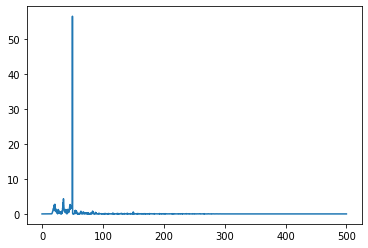

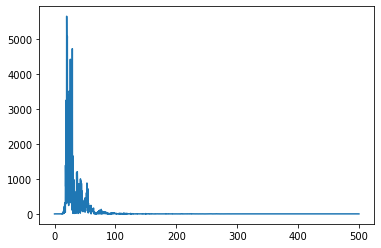

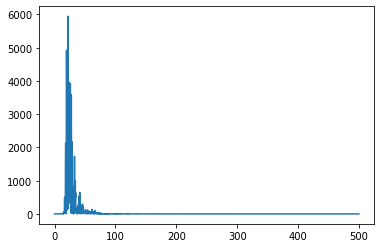

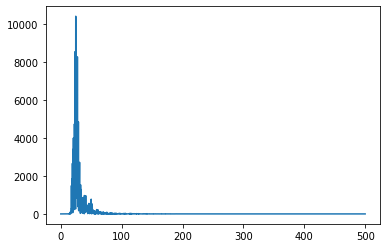

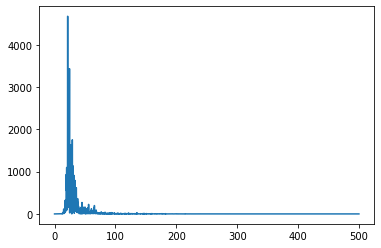

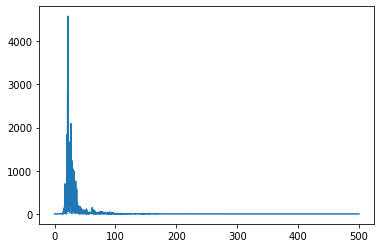

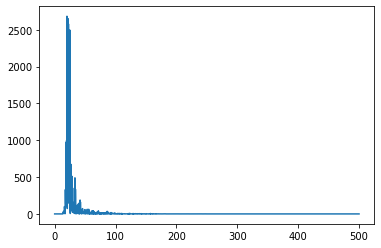

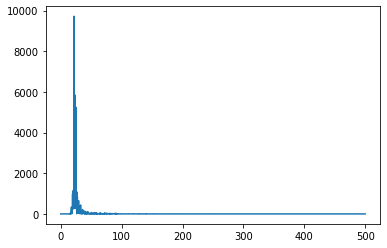

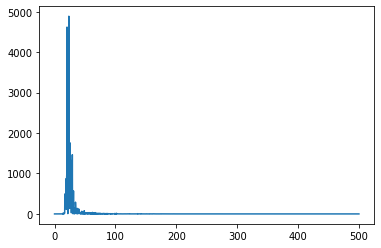

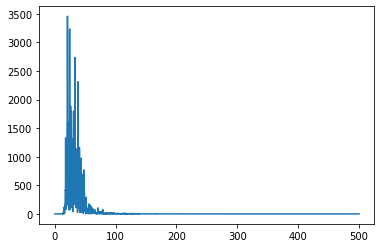

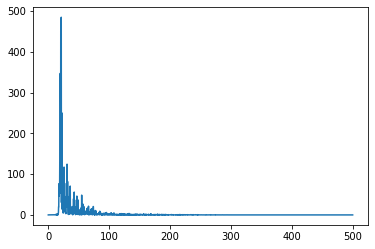

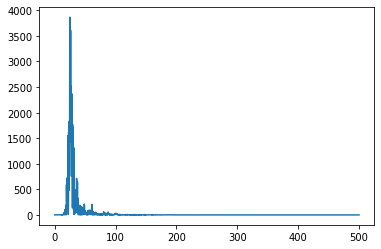

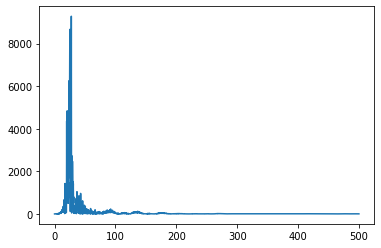

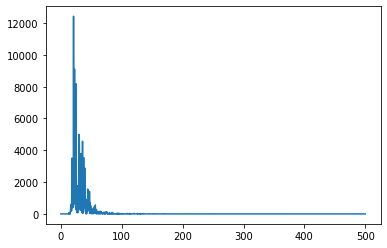

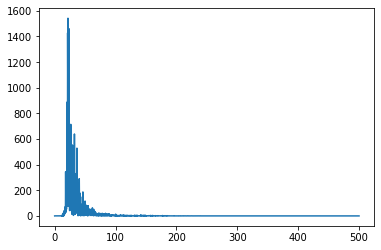

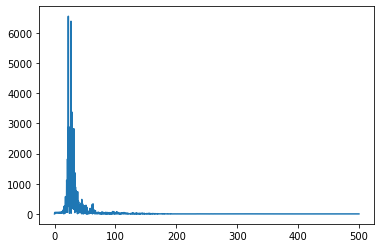

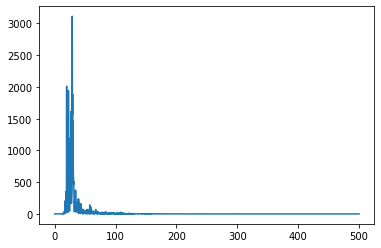

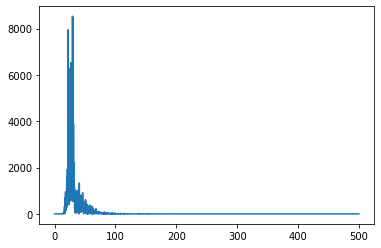

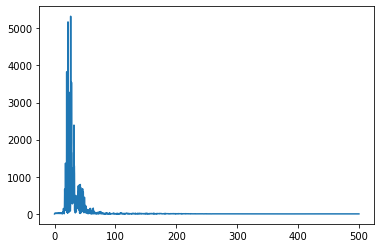

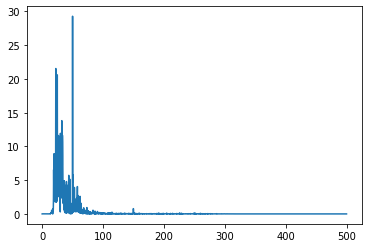

In [453]:
x_filter = signal.filtfilt(b, a, data.loc[:,data.columns[3+2]])
#x_filter = signal.filtfilt(b1, a1, x_filter)
ind = abs(zscore(x_filter))<10
x_filter[~ind]=np.median(x_filter[ind])
l = len(x_filter)
for i in range(20):
    freqs, power=signal.periodogram(x_filter[i*l//20:(i+1)*l//20], 1e3)
    plt.figure()
    plt.plot(freqs,power)

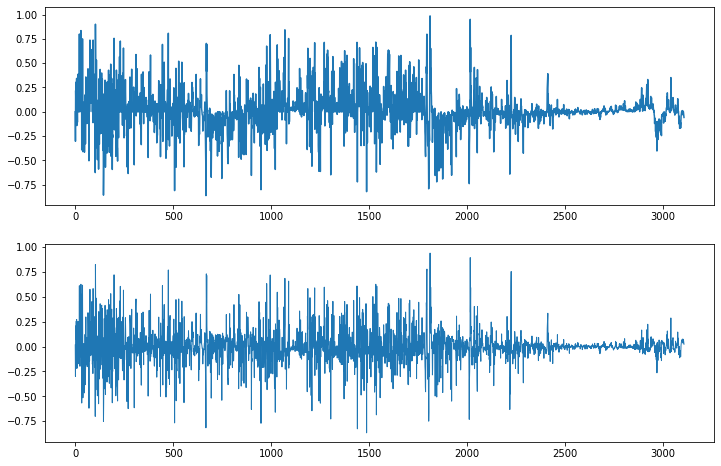

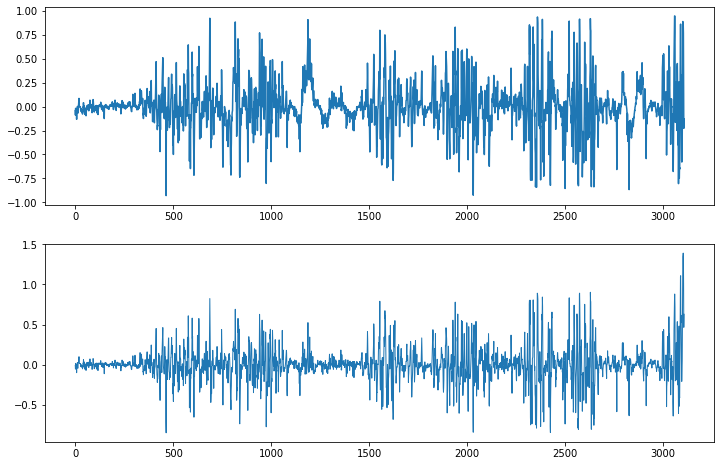

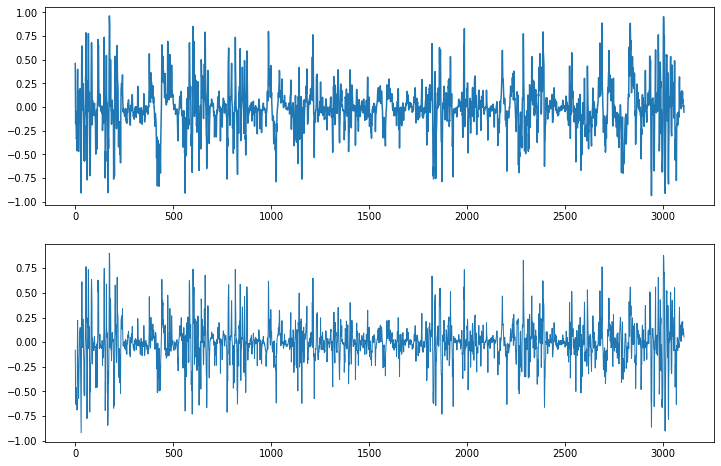

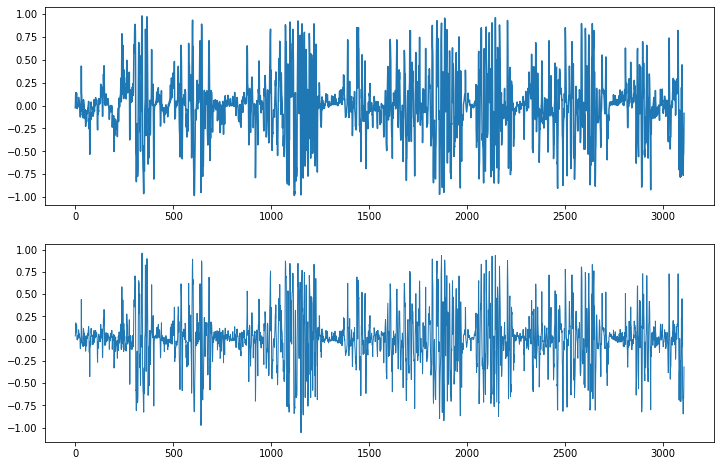

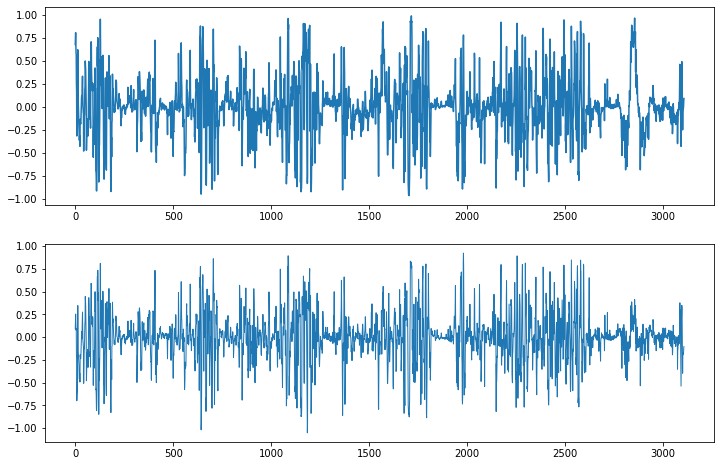

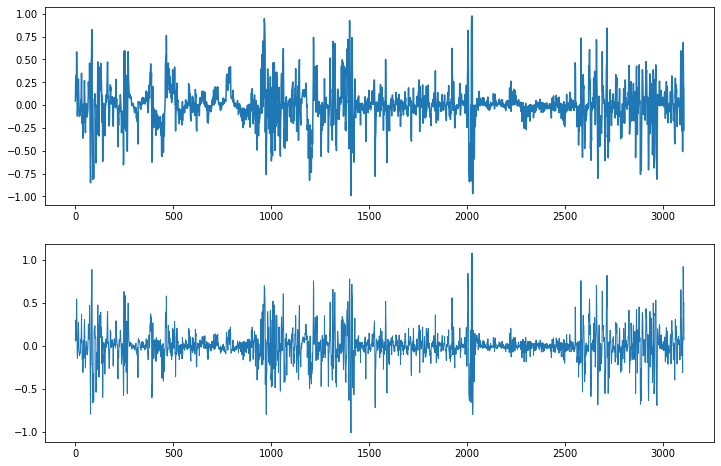

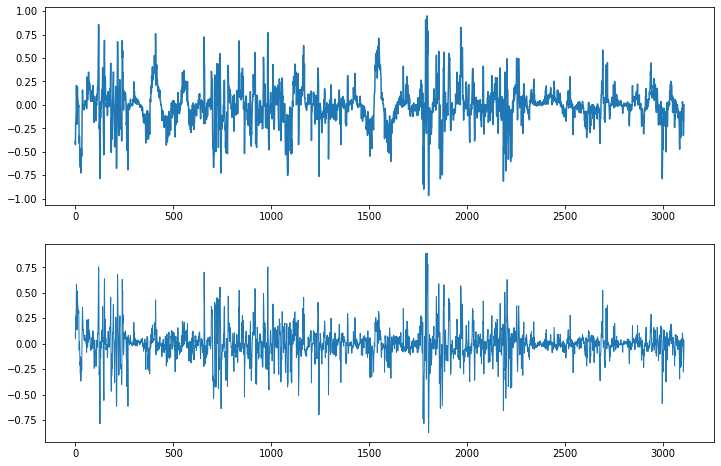

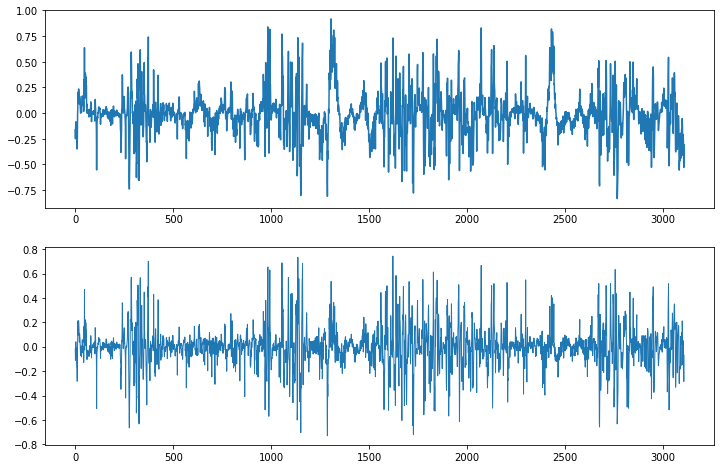

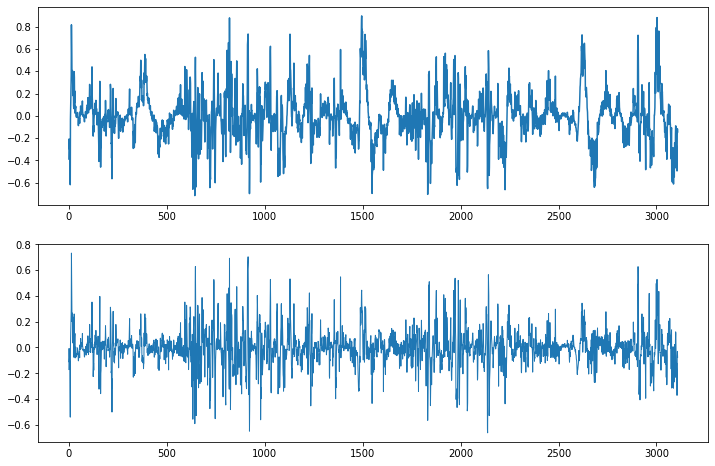

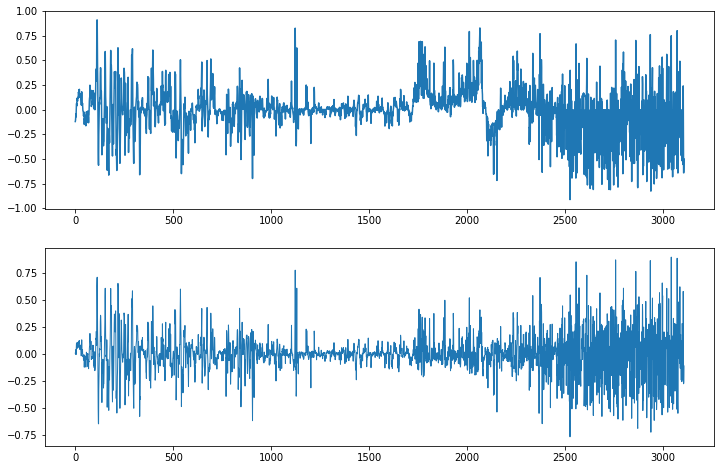

In [28]:
l=len(data)
#sc = StandardScaler()
k = 3+2
N = 10
for i in range(N):
    plt.figure(figsize=(12,8))
    plt.subplot(2,1,1)
    #data.iloc[i*10000:(i+1)*10000,7].plot(linewidth=0.5)
    temp = np.array(data.iloc[i*l//N:(i+1)*l//N,k])
    #temp = np.clip(data.iloc[i*l/5:(i+1)*l/5,7],-500,500)
    #plt.plot(sc.fit_transform(temp)[:,0])
    plt.plot(temp)
    plt.subplot(2,1,2)
    x_filter = signal.filtfilt(b1, a1, data.iloc[:,k])
    #x_filter = signal.filtfilt(b1, a1, x_filter)
    ind = abs(zscore(x_filter))<5
    x_filter[~ind]=np.mean(x_filter[ind])
    temp = np.array(x_filter[i*l//N:(i+1)*l//N])
    plt.plot(signal.filtfilt(b1, a1, temp),linewidth=1)
    #plt.ylim((-500,500))
    #plt.plot(temp[i*10000:(i+1)*10000])

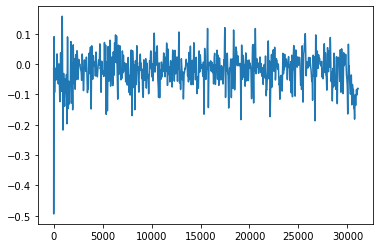

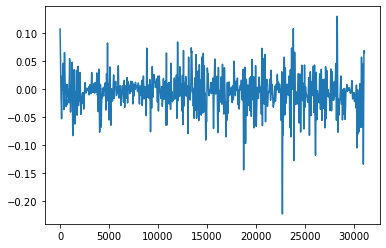

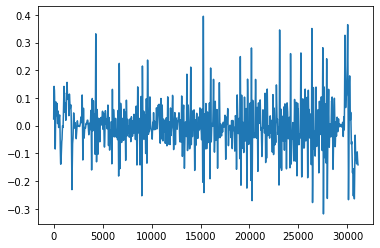

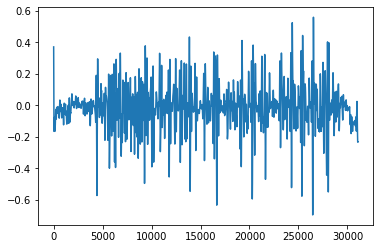

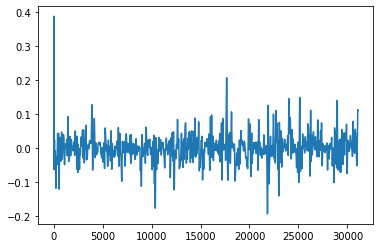

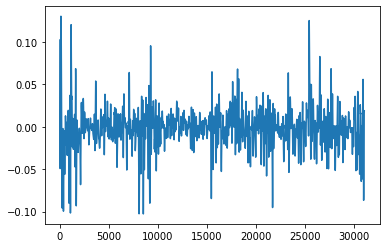

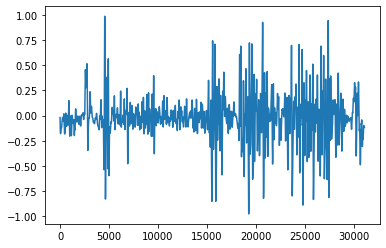

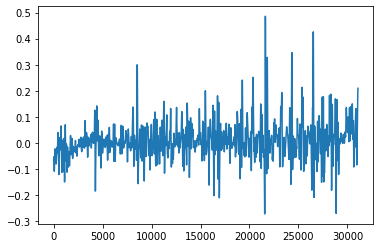

In [26]:
#temp = sc.fit_transform(data.iloc[:,3:])
for i in np.arange(3,11):
    plt.figure()
    #freqs, power=signal.periodogram(signal.filtfilt(b, a, np.clip(data.loc[:,data.columns[i]],-500,500)), 1e3)
    #freqs, power=signal.periodogram(data.iloc[:,i], 1e3)
    x_filter = signal.filtfilt(b, a, data.loc[:,data.columns[i]])
    #x_filter = signal.filtfilt(b1, a1, x_filter)
    ind = abs(zscore(x_filter))<10
    x_filter[~ind]=np.median(x_filter[ind])
    #x_filter = sc.fit_transform(x_filter[:,np.newaxis])
    plt.plot(x_filter)

    plt.show()

In [66]:
set(data.Label2)
'%f'%freqs[ind2]

'61.230260'

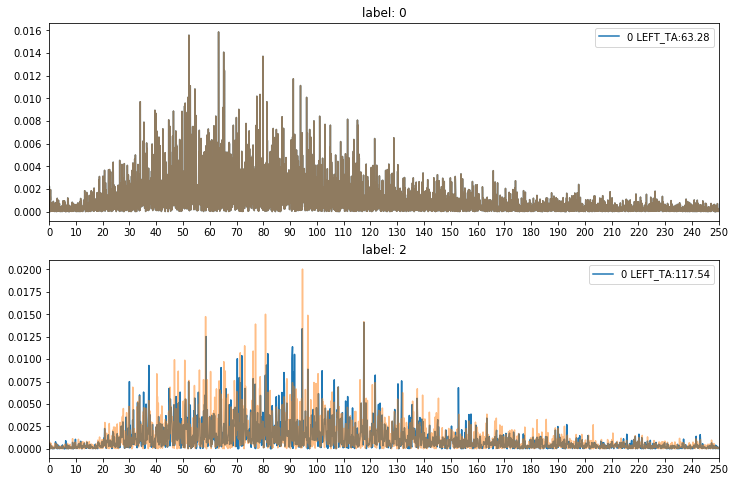

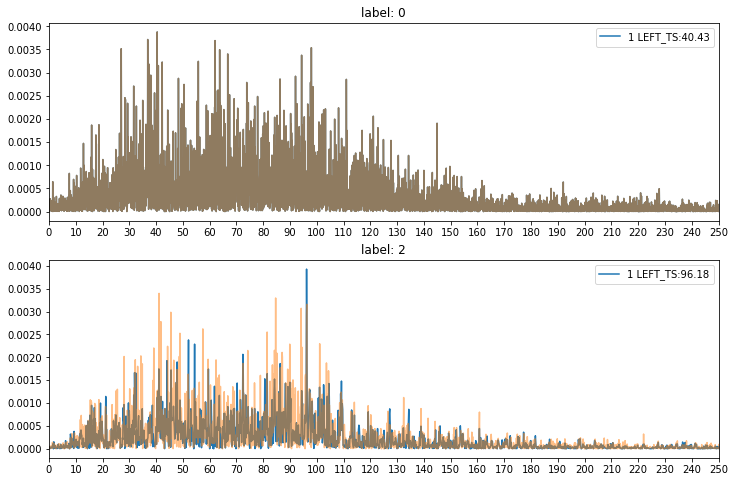

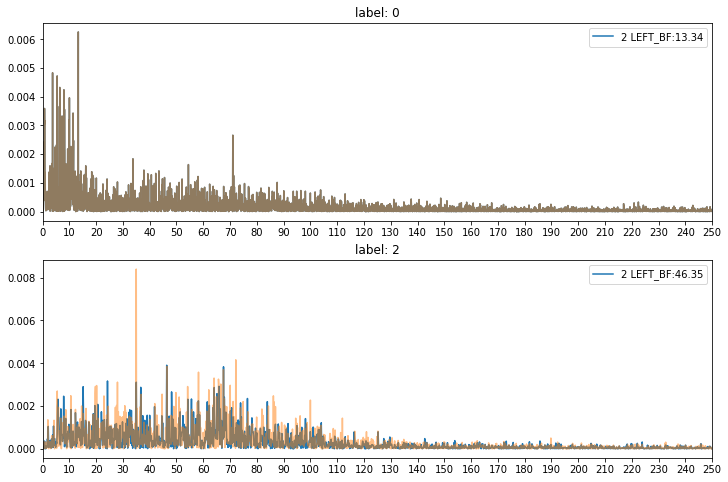

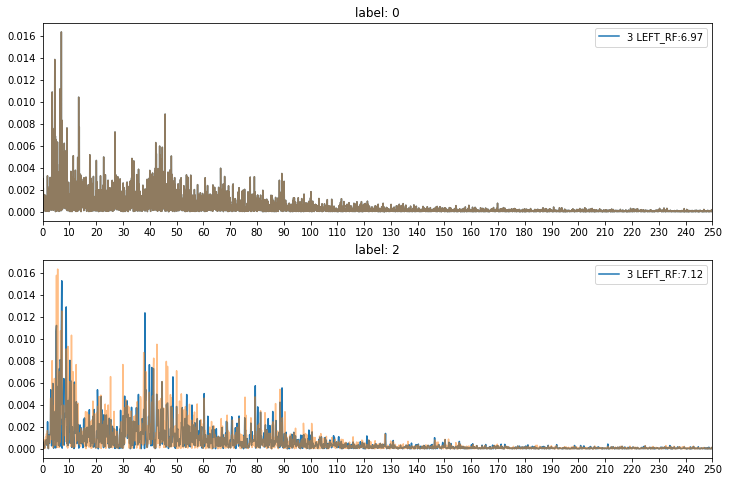

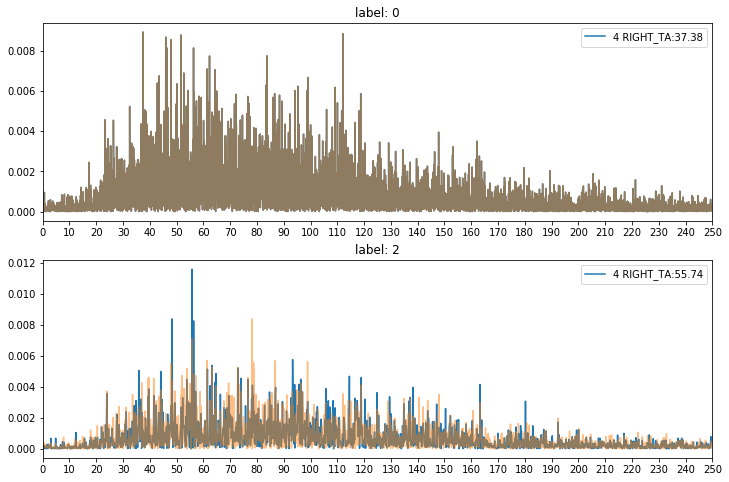

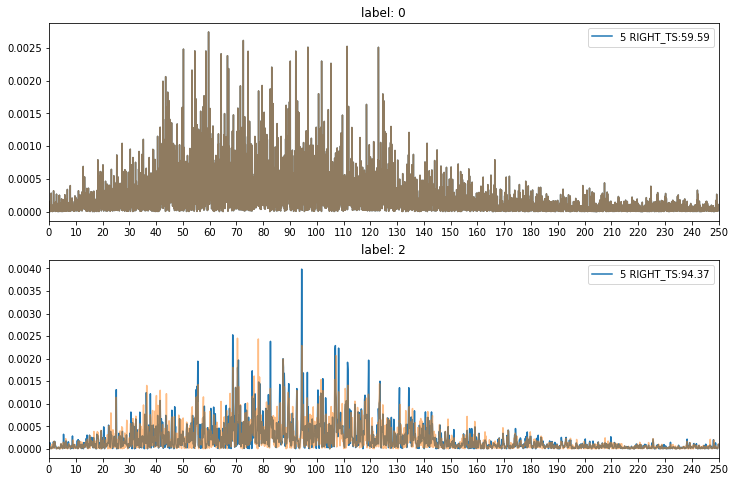

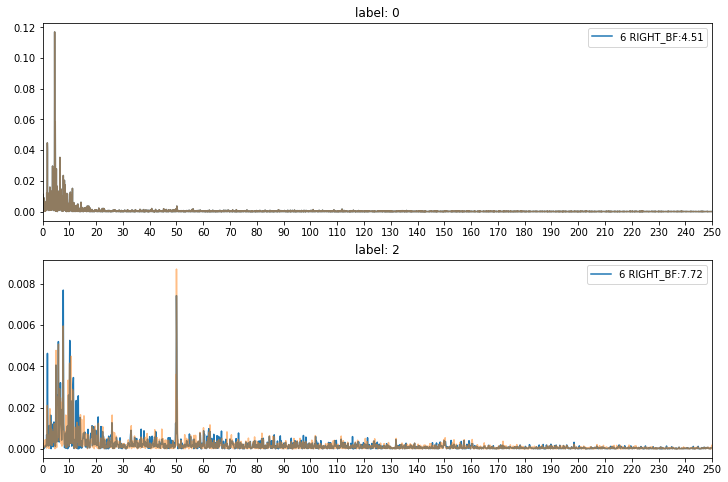

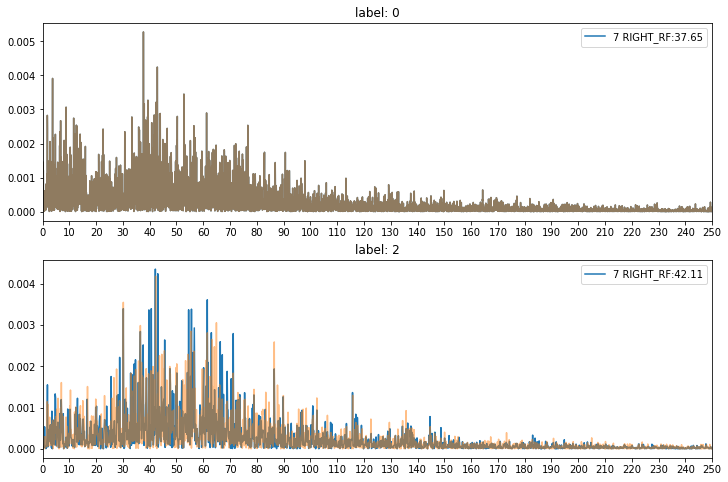

In [24]:
for i in range(8):
    plt.figure(figsize=(12,8))
    plt.title(data.columns[i+3])
    lab = 0
    for j in set(data.Label2):
        lab+=1
        ind = (data.Label2 == j) & (data.Label1 == j)
        ind3 = data.Label2 == j
        freqs,power = signal.periodogram(data.loc[ind,data.columns[3+i]],1e3)
        freqs2,power2 = signal.periodogram(data.loc[ind3,data.columns[3+i]],1e3)
        ind2 = np.argmax(power)
        
        plt.subplot(2,1,lab)
        
        plt.title('label: %d'%j)
        plt.plot(freqs,power)
        plt.plot(freqs2,power2,alpha=0.5)
        plt.xticks(np.arange(0,500,10))
        plt.xlim((0,250))
        plt.legend(labels=('%d %s:%0.2f'%(i,data.columns[i+3],freqs[ind2]),))

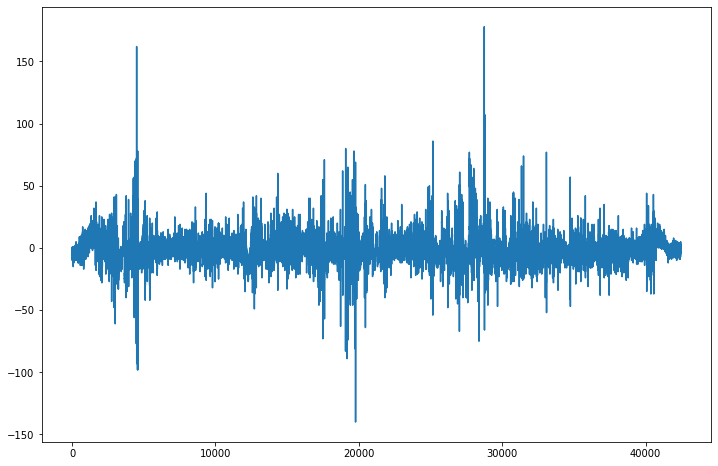

In [261]:
ind = data.Label2 == 0
a = np.array(data.index[ind])
np.where(a[1:]-a[:-1]>1)
plt.figure(figsize=(12,8))
#data.loc[ind,'LEFT_TS'].plot()
plt.plot(np.array(data.loc[ind,'LEFT_TS']))
#a[5589]

(0, 250)

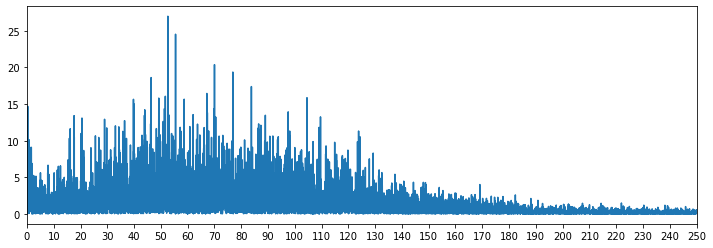

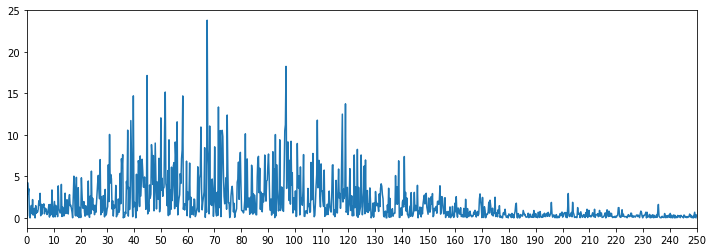

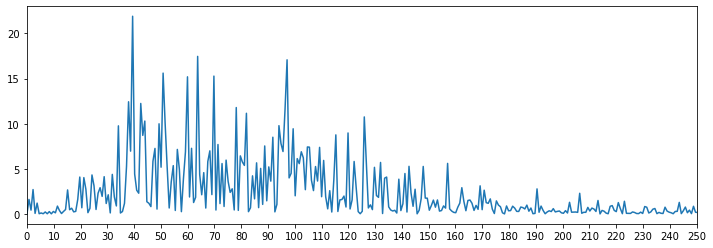

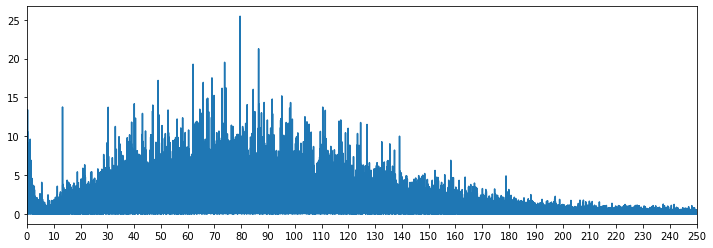

In [255]:
ind = data.Label2 == 0
a = np.array(data.index[ind])
plt.figure(figsize=(12,4))
#data.loc[ind,'LEFT_BF'].plot()
freqs,power = signal.periodogram(data.loc[ind,'LEFT_BF'],1e3)
plt.plot(freqs,power)
plt.xticks(np.arange(0,500,10))
plt.xlim((0,250))

plt.figure(figsize=(12,4))
freqs,power = signal.periodogram(data.iloc[:4280,2+3],1e3)
plt.plot(freqs,power)
plt.xticks(np.arange(0,500,10))
plt.xlim((0,250))

plt.figure(figsize=(12,4))
freqs,power = signal.periodogram(data.iloc[9681:10999,2+3],1e3)
plt.plot(freqs,power)
plt.xticks(np.arange(0,500,10))
plt.xlim((0,250))

plt.figure(figsize=(12,4))
freqs,power = signal.periodogram(data.iloc[15951:,2+3],1e3)
plt.plot(freqs,power)
plt.xticks(np.arange(0,500,10))
plt.xlim((0,250))

In [154]:
data.iloc[15952,2]

0

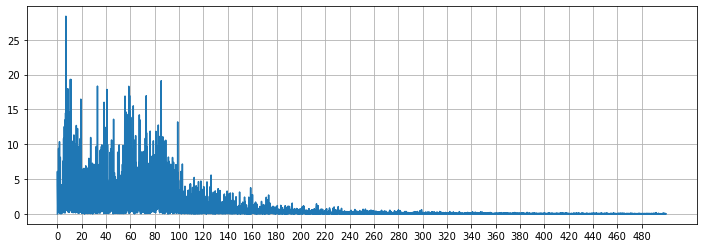

In [162]:
a = np.array(data.iloc[:4280,2+3])
b = np.array(data.iloc[9681:10999,2+3])
c = np.array(data.iloc[15951:,2+3])
d = np.concatenate([c])
freqs,power = signal.periodogram(d,1e3)
plt.figure(figsize=(12,4))
plt.plot(freqs,power)
plt.xticks(np.arange(0,500,20))
plt.grid(True)
#plt.xlim((0,250))
plt.savefig('./test.jpg')

In [194]:
df.columns

Index(['G04_FoG_trial_1_emg.csv', 'G04_FoG_trial_2_emg.csv',
       'G06_FoG_trial_1_emg.csv', 'G06_FoG_trial_2_emg.csv',
       'G06_FoG_trial_3_emg.csv', 'G07_Freezing_Trial1_trial_1_emg.csv',
       'G08_FoG_1_trial_1_emg.csv', 'G08_FoG_2_trial_1_emg.csv',
       'G11_FoG_trial_1_emg.csv', 'G11_FoG_trial_2_emg.csv',
       'P379_M050_2_OFF_A_FoG_trial_1_emg.csv',
       'P379_M050_2_OFF_A_FoG_trial_2_emg.csv',
       'P379_M050_2_OFF_A_FoG_trial_3_emg.csv',
       'P379_M050_2_OFF_B_FoG_trial_1_emg.csv',
       'P379_M050_2_OFF_B_FoG_trial_2_emg.csv',
       'P379_M050_2_OFF_B_FoG_trial_3_emg.csv',
       'P551_M050_2_A_FoG_trial_1_emg.csv',
       'P551_M050_2_B_FoG_trial_1_emg.csv',
       'P551_M050_2_B_FoG_trial_2_emg.csv',
       'P812_M050_2_B_FoG_trial_1_emg.csv',
       'P812_M050_2_B_FoG_trial_2_emg.csv'],
      dtype='object')

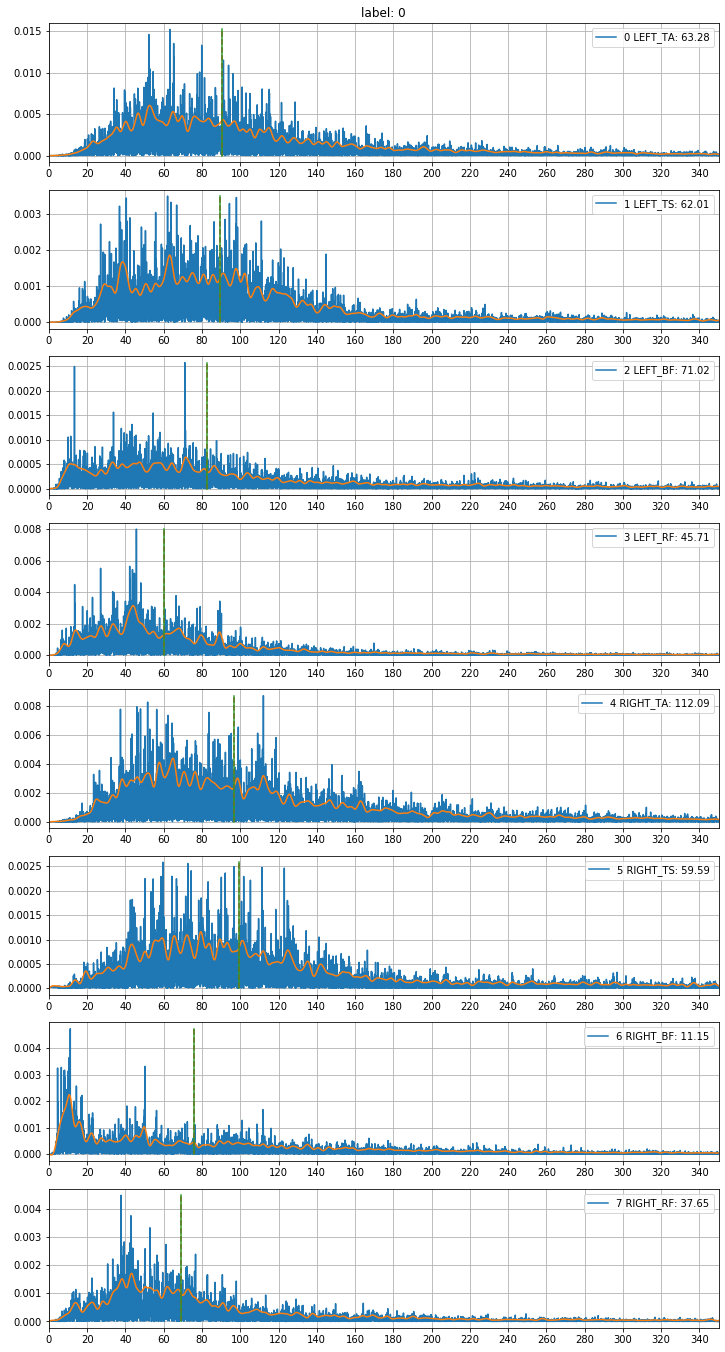

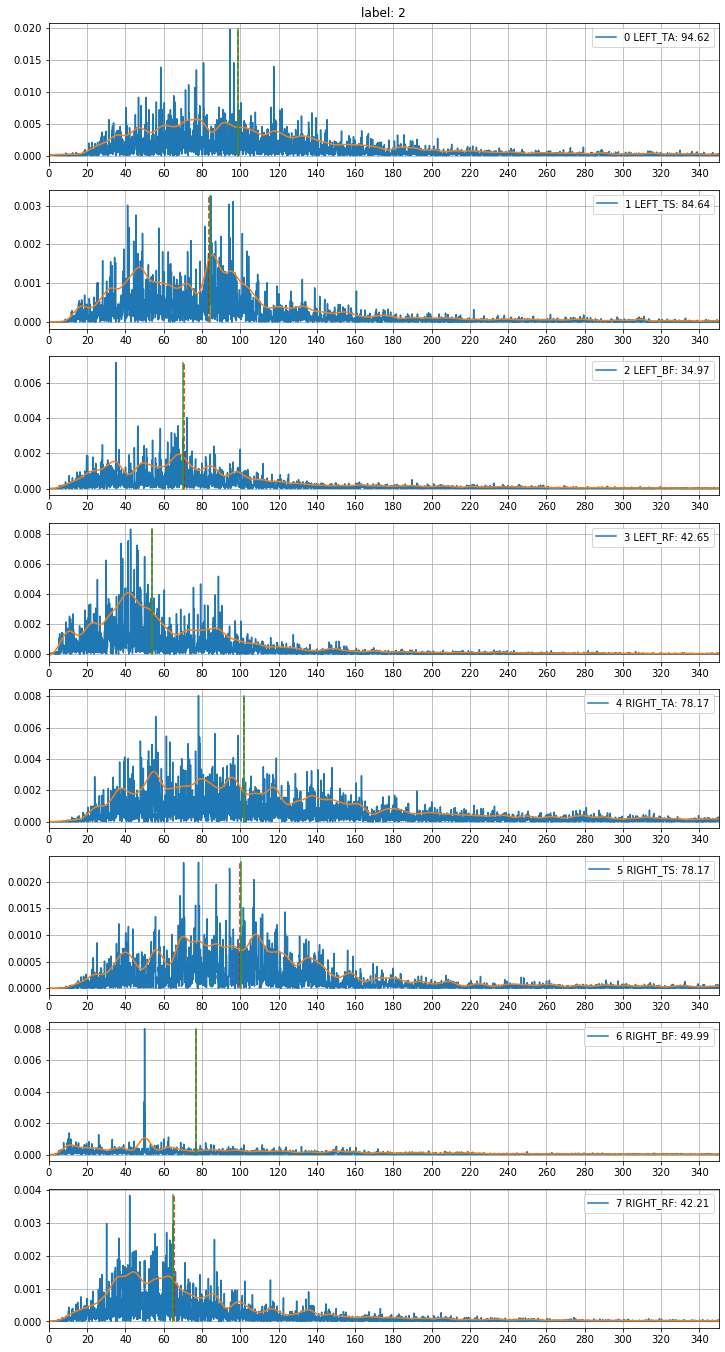

In [23]:
fn = 10
wn=2*fn/1000
b, a = signal.butter(4, wn, 'lowpass')
b1, a1 = signal.butter(1, wn, 'highpass')
length = len(df.columns)
for fi in np.arange(2,3):
    data = pd.read_csv('./data/'+df.columns[3])
    data = data.fillna({'LEFT_TA':data.LEFT_TA.mean(),
                           'LEFT_TS':data.LEFT_TS.mean(),
                           'LEFT_BF':data.LEFT_BF.mean(),
                           'LEFT_RF':data.LEFT_RF.mean(),
                           'RIGHT_TA':data.RIGHT_TA.mean(),
                           'RIGHT_TS':data.RIGHT_TS.mean(),
                           'RIGHT_BF':data.RIGHT_BF.mean(),
                           'RIGHT_RF':data.RIGHT_RF.mean()})
    #data = data.dropna().reset_index(drop=True)
    data.iloc[:,3:] = normalize(data.iloc[:,3:])
    for i in set(data.Label2):
        plt.figure(figsize=(12,24))
        #plt.title(data.columns[i+3])
        ind = data.Label2 == i
        plt.title('label: %d'%i)
        for j in range(8):

            freqs,power = signal.periodogram(signal.filtfilt(b1,a1,data.loc[ind,data.columns[3+j]]),1e3)            
            
            ind2 = np.argmax(power)
            power_filt = signal.filtfilt(b, a, power)*2
            
            total = cumtrapz(power_filt,freqs)
            w=np.where(total>=(total[-1]/2))[0][0]
            
            total2 = cumtrapz(power,freqs)
            w2=np.where(total2>=(total2[-1]/2))[0][0]            
            
            plt.subplot(8,1,j+1)
            if j == 0:
                plt.title('label: %d'%i)
            plt.plot(freqs,power)
            plt.plot(freqs,power_filt)
            plt.plot([freqs[w],freqs[w]],[0,power.max()],linestyle='--',color='r')
            plt.plot([freqs[w2],freqs[w2]],[0,power.max()],linestyle='-')
            plt.xticks(np.arange(0,500,20))
            plt.xlim((0,350))
            plt.grid(True)
            plt.legend(labels=('%d %s: %0.2f'%(j,data.columns[j+3],freqs[ind2]),))
        #plt.savefig('./pic/label_%d/'%i+df.columns[fi].split('.')[0]+'.jpg')
        #plt.close()

In [207]:
fn = 30
wn=2*fn/1000
b, a = signal.butter(4, wn, 'lowpass')
#x_filter = signal.filtfilt(b, a, x[1,:,1])

E:\ProgramData\Anaconda3\lib\site-packages\pywt\_functions.py:142: FutureWarning: Wavelets from the family shan, without parameters specified in the name are deprecated. The name should takethe form shanB-C where B and C are floats representing the bandwidth frequency and center frequency, respectively (example: shan1.5-1.0).
  wavelet = DiscreteContinuousWavelet(wavelet)


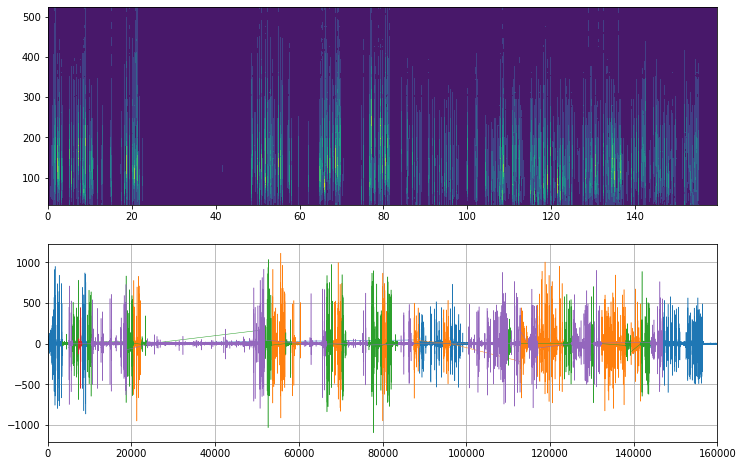

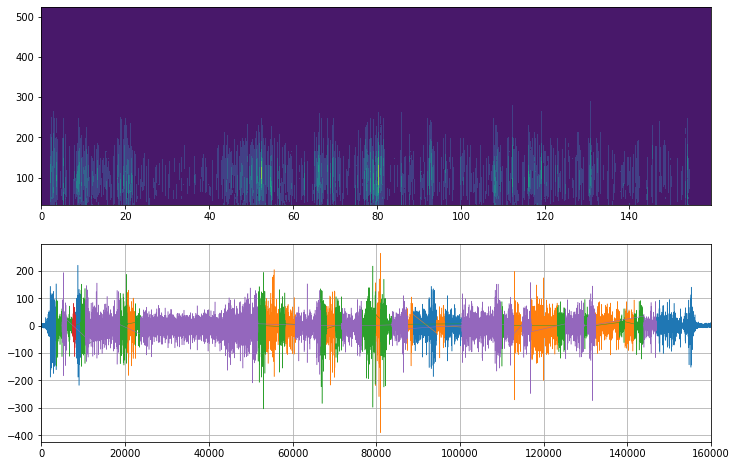

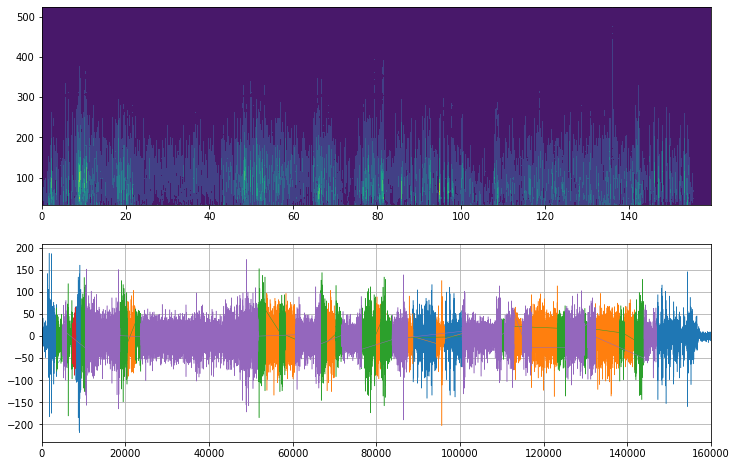

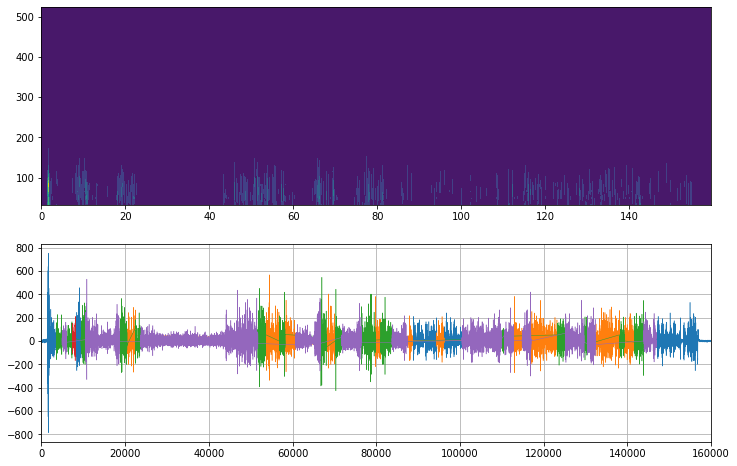

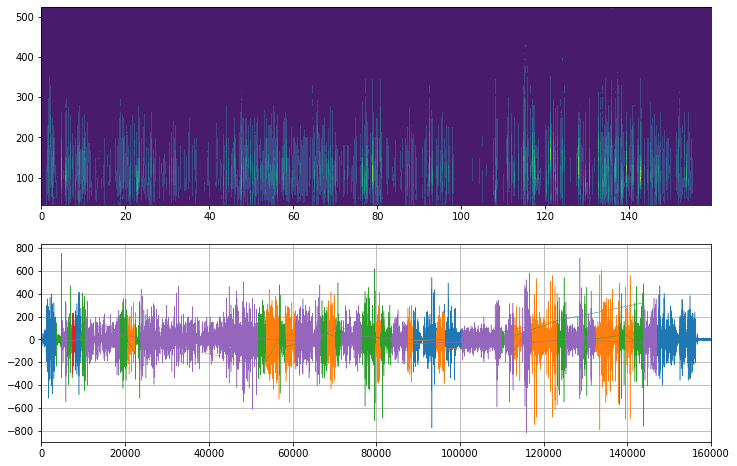

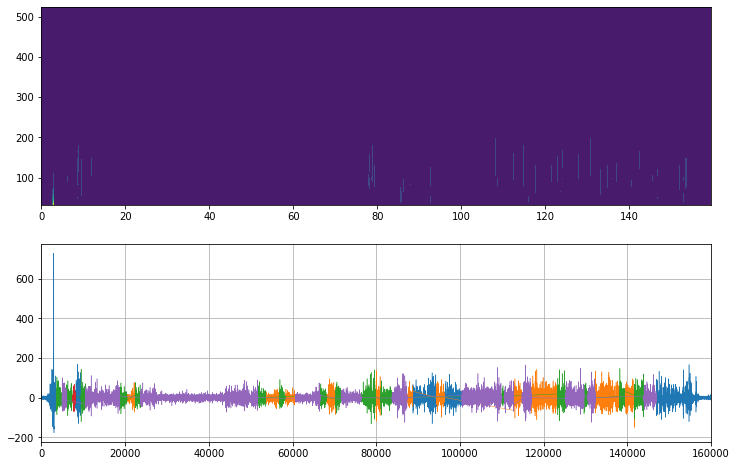

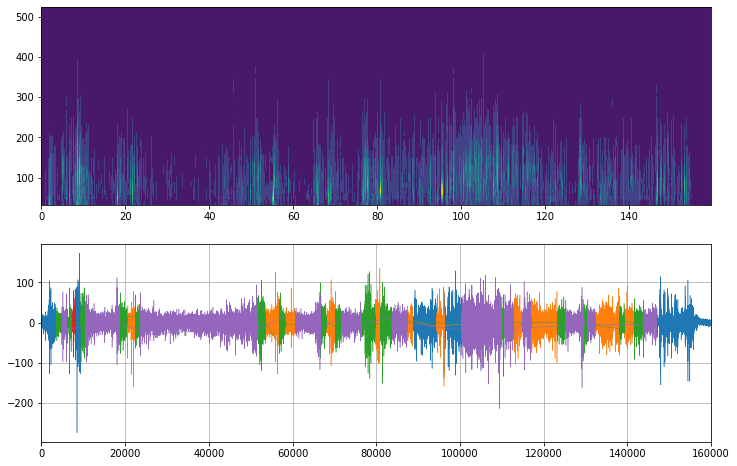

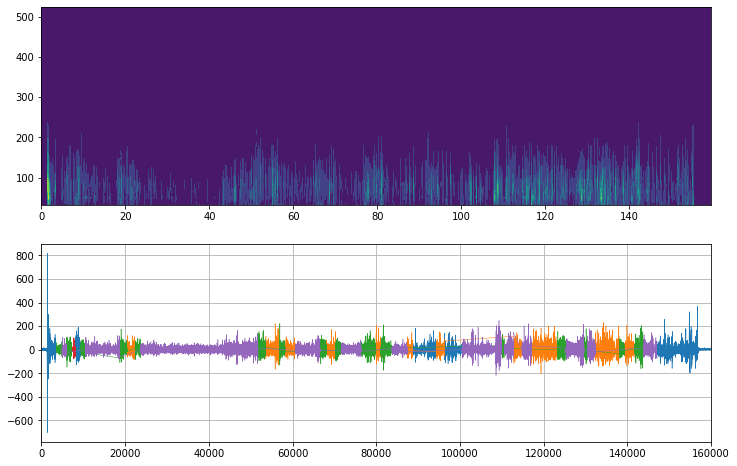

In [90]:
fc = pywt.central_frequency('shan')
totalscal=32
cparam = 2 * fc * totalscal
scales = cparam / np.arange(totalscal, 1, -1)
t = np.arange(0,len(data)/1000,1e-3)

fn = 20
wn=2*fn/1000
b, a = signal.butter(4, wn, 'highpass')

for i in np.arange(3,11):
    plt.figure(figsize=(12,8))
    plt.subplot(2,1,1)
    #x_filter = signal.filtfilt(b,a,data.iloc[:,i])
    #data.loc[:,data.columns[i]].plot(linewidth=0.5)
    cwtmatr,f = pywt.cwt(data.loc[:,data.columns[i]],scales,'morl',1e-3)
    plt.contourf(t, f, abs(cwtmatr))
    plt.subplot(2,1,2)
    for j in set(data.Label2):
        ind = data.Label2 == j
        data.loc[ind,data.columns[i]].plot(linewidth=0.5)
        #sns.lineplot(data.Time[ind],x_filter[ind],linewidth=0.3)
        #plt.ylim((-200,200))
        plt.xlim((0,160000))
        plt.grid(True)
    #print(freqs[np.argmax(power)])

In [24]:
x.shape

(44530, 256, 8)

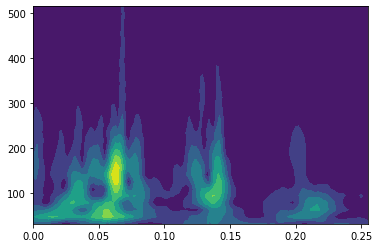

In [126]:
wave='cgau8'
fc = pywt.central_frequency(wave)
totalscal=32
cparam = 2 * fc * totalscal
scales = cparam / np.arange(totalscal+1, 1, -1)
t = np.arange(0,0.256,1e-3)
cwtmatr,f = pywt.cwt(x[100,:,6],scales,wave,1e-3)
plt.contourf(t, f, abs(cwtmatr))

In [56]:
pywt.wavelist(kind='continuous')

['cgau1',
 'cgau2',
 'cgau3',
 'cgau4',
 'cgau5',
 'cgau6',
 'cgau7',
 'cgau8',
 'cmor',
 'fbsp',
 'gaus1',
 'gaus2',
 'gaus3',
 'gaus4',
 'gaus5',
 'gaus6',
 'gaus7',
 'gaus8',
 'mexh',
 'morl',
 'shan']

In [33]:
temp.shape

(2, 32, 256, 8)

In [41]:
temp=dp.generate_CWT_feature(x[100:102])

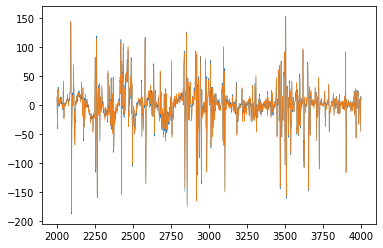

In [268]:
data.iloc[2000:4000,4].plot(linewidth=0.5)
plt.plot(np.arange(2000,4000),temp[2000:4000],alpha=0.9,linewidth=0.5)

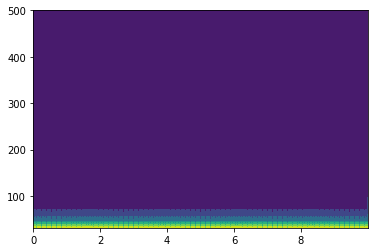

In [7]:
x = np.arange(0,10,0.001)
y = np.sin(2*np.pi*10*x)
fc = pywt.central_frequency('mexh')
totalscal=32
cparam = 2 * fc * totalscal
scales = cparam / np.arange(totalscal, 1, -1)
#plt.plot(y)
[cwtmatr, frequencies] = pywt.cwt(y,scales,'mexh',1e-3)
plt.contourf(x, frequencies, abs(cwtmatr))

In [13]:
f

array([500.   , 484.375, 468.75 , 453.125, 437.5  , 421.875, 406.25 ,
       390.625, 375.   , 359.375, 343.75 , 328.125, 312.5  , 296.875,
       281.25 , 265.625, 250.   , 234.375, 218.75 , 203.125, 187.5  ,
       171.875, 156.25 , 140.625, 125.   , 109.375,  93.75 ,  78.125,
        62.5  ,  46.875,  31.25 ])

11


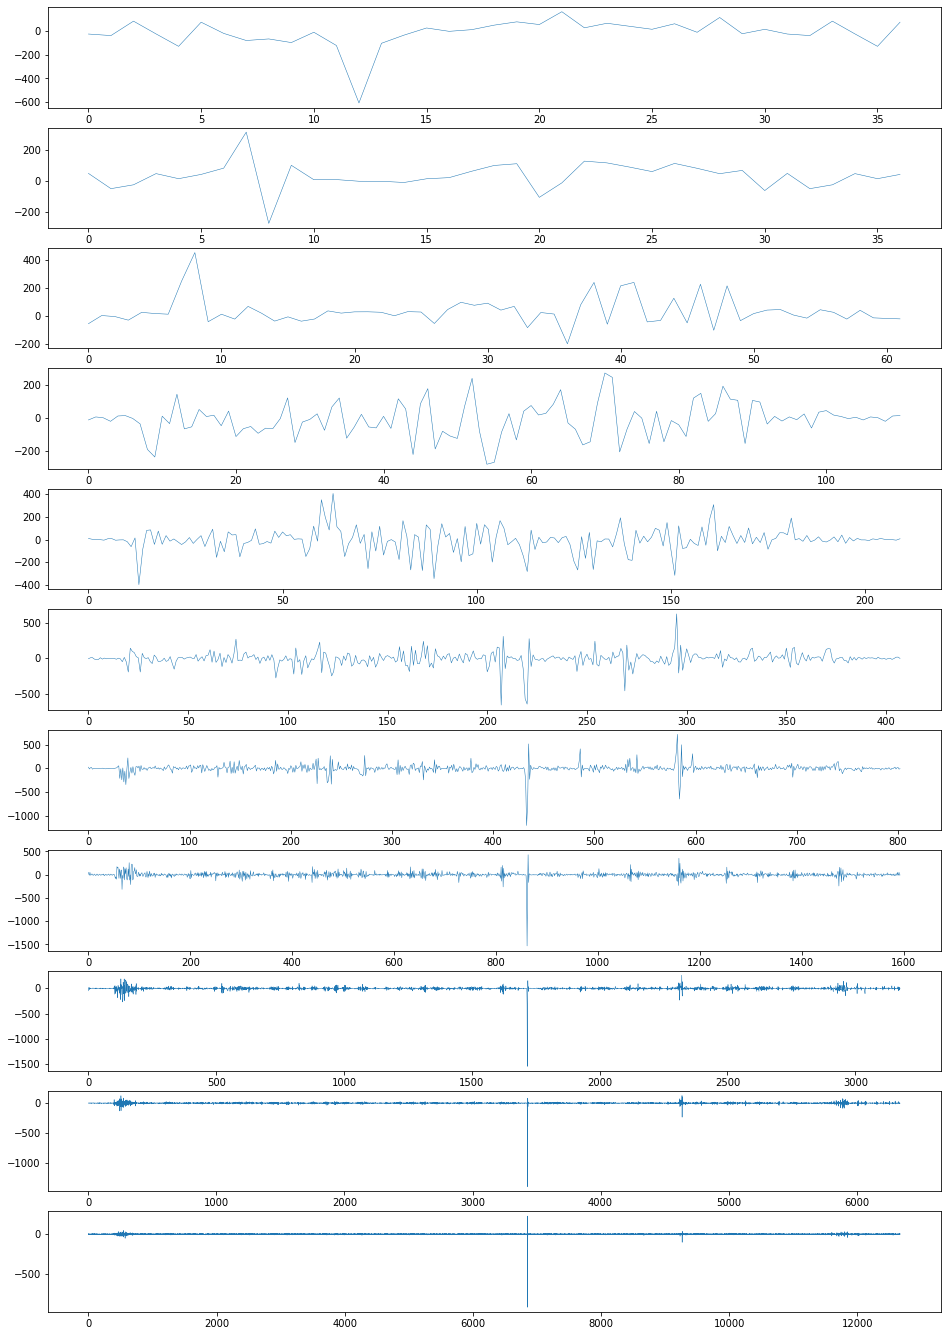

In [6]:
plt.figure(figsize=(16,24))
wa = pywt.wavedec(data.iloc[:,10],'db7',4,level=None)
j = 0
for i in wa:
    j += 1
    plt.subplot(len(wa),1,j)
    plt.plot(i,linewidth=0.5)
print(len(wa)) 

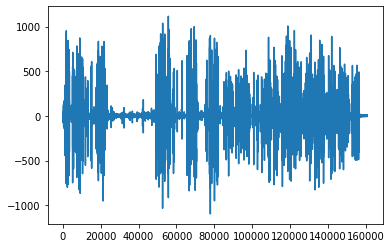

In [46]:
data.iloc[:,3].plot()

In [117]:
#for i in range(len(scs)):
#    joblib.dump(scs[i], './model/scalar%d'%i)
joblib.dump(sc, './model/scalar')

['./model/scalar']

In [15]:
data.isna().sum()

Time        0
Label1      0
Label2      0
LEFT_TA     0
LEFT_TS     0
LEFT_BF     0
LEFT_RF     0
RIGHT_TA    0
RIGHT_TS    0
RIGHT_BF    0
RIGHT_RF    0
dtype: int64

In [115]:
width = 256
stride = 64
widths_scale = 32
x,y = dp.generate_window_slide_data(emg_data2,width,stride,scaler=True)

In [78]:
import time
import sys

In [96]:
start = time.time()
cwtmatr = generate_CWT_feature(x,widths_scale)
end = time.time()
duration = end-start
print('duration: %f'%(duration))

duration: 57.133043


In [ ]:
import h5py

file = './processed data/P812_trial_1_W%d_S%d_WS%d_CWT.hdf5'%(width,stride,widths_scale)
#with h5py.File(file,'w') as f:
#    f.create_dataset('cwt_data',data=cwtmatr)
#    f.create_dataset('label2',data=y)
    
with h5py.File(file,'r') as f:
    cwtmatr = f['cwt_data'][...]
    y = f['label2'][...]

In [20]:
dp.compute_AR(x).shape

(2196, 8)

1


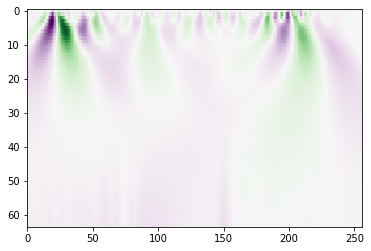

In [98]:
temp = 650
plt.imshow(cwtmatr[temp,:,:,0], cmap='PRGn', aspect='auto',
           vmax=abs(cwtmatr[temp,:,:,0]).max(), 
           vmin=-abs(cwtmatr[temp,:,:,0]).max())
print(y[temp])

In [94]:
print('max: %f'%(cwtmatr.max()))

max: 10774.616683


In [93]:
sys.getsizeof(cwtmatr)

4601151632

In [20]:
path = './processed data/data_set_after_window.hdf5'
with h5py.File(path,'r') as f:
    x = f['cwt_data'][...]
    y = f['label2'][...]

In [22]:
x.shape

(44530, 256, 8)

In [4]:
feature = dp.generate_feature(x)

In [5]:
ind = (y==2)

In [8]:
ind2 = (y==0)

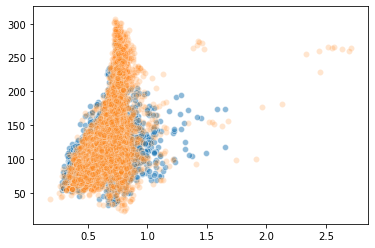

In [45]:
f1 = 8
f2 = 40
sns.scatterplot(feature[ind,f1],feature[ind,f2],alpha=0.5)
sns.scatterplot(feature[ind2,f1],feature[ind2,f2],alpha=0.2)

In [28]:
a = np.array([1,2,3,4])
ak,sig = autoregressive.AR_est_YW(a,3)

In [29]:
a[:3]@ak+sig

4.373102815177478

In [30]:
dwt = pywt.wavedec(x[1,:,1],wavelet='db7',level=3)

In [56]:
temp = np.array(dwt[0])
for i in range(len(dwt)-1):
    temp = np.concatenate([temp,np.array(dwt[i+1])])
l=0
for i in dwt:
    l+=len(i)
    print(len(i))

43
43
73
134


In [57]:
len(temp)

293

In [82]:
np.clip(np.random.randint(-5,5,(3,3)),0,4)

array([[0, 2, 0],
       [0, 3, 4],
       [3, 0, 0]])

In [84]:
!pip install joblib

In [26]:
a=[]
b=np.random.randint(0,10,(3,3,3))
c=np.random.randint(0,10,(3,3,3))
len(np.array(c.tolist() + b.tolist()))

6

In [18]:
a=pd.read_csv('./index_wrong_predict_ann.csv')
c=pd.read_csv('./index_wrong_predict_cnn.csv')

In [45]:
(pd.concat([a,c],axis=0).iloc[:,0].value_counts()==2).value_counts()

False    873
True     182
Name: 0, dtype: int64

In [23]:
a.T

0    1    2    3    4    5    6    7    8    9    ...   555   556   557  \
0    0    5   18   19   20   42   43   94   95   96  ...  1920  1921  1922   

    558   559   560   561   562   563   564  
0  1923  1925  2019  2032  2033  2034  2074  

[1 rows x 565 columns]

In [31]:
c.T

0    1    2    3    4    5    6    7    8    9    ...   662   663   664  \
0    0    1    2    3   19   72   79   83   84   85  ...  1972  1973  1978   

    665   666   667   668   669   670   671  
0  2041  2071  2072  2073  2074  2076  2078  

[1 rows x 672 columns]